<a href="https://colab.research.google.com/github/FerArvizu29/NFL_ranking/blob/main/ValoracionJugadasNFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Valoración en la NFL basada en jugadas ofensivas de alta presión.**

## Por: Arvizu Vargas Fernando.

### Importamos las librerías.

In [1]:
# Liberías.
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties
import os
from collections import defaultdict
pd.set_option('display.max_columns', 30)

### Importamos los datos.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pbp_2024 = pd.read_csv('/content/drive/MyDrive/play_by_play_nfl/pbp_2024.txt', sep=';', low_memory=False)
len(pbp_2024)

49492

In [4]:
pbp_2024

,Unnamed: 0,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,...,id,fantasy_player_name,fantasy_player_id,fantasy,fantasy_id,out_of_bounds,home_opening_kickoff,qb_epa,xyac_epa,xyac_mean_yardage,xyac_median_yardage,xyac_success,xyac_fd,xpass,pass_oe
0,1,1,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,NaN,NaN,NaN,NaN,NaN,2024-09-08,900.0,...,NaN,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,40,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,BUF,35.0,2024-09-08,900.0,...,NaN,NaN,NaN,NaN,NaN,0,0,"0,257819156162441",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,61,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,ARI,70.0,2024-09-08,900.0,...,00-0033553,J.Conner,00-0033553,J.Conner,00-0033553,0,0,"-0,200602158438414",NaN,NaN,NaN,NaN,NaN,"0,456761032342911","-45,6761032342911"
3,4,83,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,ARI,67.0,2024-09-08,867.0,...,00-0035228,J.Conner,00-0033553,J.Conner,00-0033553,0,0,"2,02887390041724","1,34541813996774","9,32122089374752",8.0,"0,509777886181837","0,363807102054125","0,576655685901642","42,3344314098358"
4,5,108,2024_01_ARI_BUF,2024090801,BUF,ARI,REG,1,ARI,away,BUF,BUF,45.0,2024-09-08,823.0,...,00-0035228,J.Conner,00-0033553,J.Conner,00-0033553,0,0,"0,754242303897627","0,882798267217859","5,78355986060342",4.0,"0,668478149455041","0,255139816086739","0,426443099975586","57,3556900024414"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49487,49488,4158,2024_22_KC_PHI,2025020900,PHI,KC,POST,22,PHI,home,KC,KC,35.0,2025-02-09,108.0,...,NaN,NaN,NaN,NaN,NaN,0,1,"1,10217883216683",NaN,NaN,NaN,NaN,NaN,NaN,NaN
49488,49489,4181,2024_22_KC_PHI,2025020900,PHI,KC,POST,22,PHI,home,KC,KC,44.0,2025-02-09,107.0,...,00-0038102,K.Pickett,00-0038102,K.Pickett,00-0038102,0,1,"-0,599591913167387",NaN,NaN,NaN,NaN,NaN,NaN,NaN
49489,49490,4203,2024_22_KC_PHI,2025020900,PHI,KC,POST,22,PHI,home,KC,KC,46.0,2025-02-09,65.0,...,00-0038102,K.Pickett,00-0038102,K.Pickett,00-0038102,0,1,"-0,431691241334192",NaN,NaN,NaN,NaN,NaN,NaN,NaN
49490,49491,4225,2024_22_KC_PHI,2025020900,PHI,KC,POST,22,PHI,home,KC,KC,47.0,2025-02-09,27.0,...,00-0038102,K.Pickett,00-0038102,K.Pickett,00-0038102,0,1,"-0,897923534153961",NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Criterio para asignar un valor base a cada jugada, basada en su éxito.

Para ponderar las jugadas, necesitamos saber si son exitosas o fallidas.

In [5]:
def calcular_valor_base(jugada):
    """
    Asigna una puntuación base a una jugada.
    Incluye la lógica para los nuevos play_types.
    """
    play_type = jugada['play_type']

    # Jugadas de equipos especiales.
    if play_type == 'field_goal':
        return 3 if jugada['field_goal_result'] == 'made' else -1

    if play_type == 'two_point':
        return 3 if jugada['two_point_conv_result'] == 'success' else -2

    if play_type == 'punt':
        return 0

    # Jugadas de serie ofensiva.
        # Eventos de alto impacto (negativos)
    if jugada['interception'] == 1 or jugada['fumble_lost'] == 1:
        return -15
    if jugada['safety'] == 1:
        return -10

        # Eventos de alto impacto (positivos)
    if jugada['touchdown'] == 1:
        return 10

        # Éxitos pequeños. Llegar a 1ra y 10.
    if jugada['first_down'] == 1:
        return 2 + (jugada['yards_gained'] / 6)

    # Eventos normales (carreras o pases)
    return jugada['yards_gained'] / 6

### Criterio para definir la "presión" de una jugada.

Se definió que hay jugadas de alta presión por si solas, y basadas en diferentes contextos como el tiempo, la posición en el campo en el momento de la jugada, el marcador, un tipo de jugada que influya potencialmente en el marcador. A este tipo de jugadas, por si solas, les denominaremos atómicas.

La ocurrencia de una jugada atómica como las anteriores ya agrega un factor de presión en el equipo, que puede jugar en contra para el éxito de la misma. Como se mencionó, estas son de diferentes contextos y pueden ocurrir varios de estos factores en una misma jugada, lo cuál incrementa más la presión. Con ello, se definen jugadas de mayor presión, en función de cuantas y que tipo de jugadas atómicas incluyen.

Para dejar esto más claro, se definió el siguiente sistema multiplicador, con finalidad de añadir o reducir la varolación base definida anteriormente. Este sistema, incluye 4 niveles de presión, y definirán el factor por el que se multiplicará el valor base de cada jugada.

#### **1. Presión extrema.**

Son jugadas de todo o nada, para empatar o ganar.

- Cuarta oportunidad, poco tiempo y con posibilidad de remontar.

`(down == 4) and (game_seconds_remaining <= 120) and (score_differential <= -4 ∧ score_differential >= -8)`

- Intento de gol de campo, poco tiempo y con posibilidad de remontar.

`(play_type == 'field_goal') and (game_seconds_remaining <= 120) and (score_differential >= -3 ∧ score_differential <= 0)`

- Intento de conversión, poco tiempo y con posibilidad de remontar.

`(play_type == 'two_point') and (game_seconds_remaining <= 120) and (score_differential >= -3 ∧ score_differential <= 0)`

#### **2. Presión muy alta.**

Son jugadas que no terminan el partido, pero casi, si tienen mucho peso en el desarrollo de este.

- Remontada:

`(down >= 3) and (game_seconds_remaining <= 120) and (score_differential < 0 and score_differential >= -16)`

- Zona roja decisiva.

`(down >= 3) and (yardline_100 <= 20)`

- Encajonado decisivo.

`(down >= 3) and (yardline_100 >= 95)`

#### **3. Presión alta.**

Situaciones de presión por si solas (sin combinaciones)

- Cuarta oportunidad.

`down == 4`

- Conversión.

`play_type == 'two_point'`

- Intento de gol de campo.

`play_type == 'field_goal'`

#### **4. Presión media.**

Situaciones de presión por si solas (sin combinaciones), más normales que las anteriores.
- Tercera oportunidad.

`down == 3`

- Zona roja en primera o segunda oportunidad.

`(down <= 2) and (yardline_100 <= 20)`

- Dos últimos minutos, ganando o empatado.

`game_seconds_remaining <= 120`

- Encajonado en primera o segunda oportunidad.

`(down <= 2) and (yardline_100 >= 95)`

#### **5. Normal.**
Resto de jugadas que no aparecen arriba.

In [6]:
def multiplicador_presion(jugada):
    """
    Asigna un multiplicador basado en una jerarquía de presión,
    de la más compleja (Nivel 4) a la más simple (Nivel 1).
    """
    #----------------------------------------------------------------------------
    # Nivel 4. Presión Extrema
    # Multiplicador: 6x
    game_seconds_remaining = jugada['game_seconds_remaining']
    score_differential = jugada['score_differential']
    down = jugada['down']
    play_type = jugada['play_type']

    # 4A: 4ta oportunidad y TD obligatorio (abajo por 4-8 puntos)
    condicion_4A = (
        down == 4 and
        game_seconds_remaining <= 120 and
        (score_differential <= -4 and score_differential >= -8)
    )

    # 4B: Gol de campo para empatar/ganar (abajo por 0-3 puntos)
    condicion_4B = (
        play_type == 'field_goal' and
        game_seconds_remaining <= 120 and
        (score_differential >= -3 and score_differential <= 0)
    )

    # 4C: Conversión de 2 puntos para empatar/ganar (abajo por 1-2 puntos)
    condicion_4C = (
        play_type == 'two_point' and
        game_seconds_remaining <= 120 and
        (score_differential == -2 or score_differential == -1)
    )

    if condicion_4A or condicion_4B or condicion_4C:
        return 5.0

    #----------------------------------------------------------------------------
    # Nivel 3: Presión Muy Alta.
    # Multiplicador: 4x

    # 3A: Remontada (dentro de 2 posesiones)
    condicion_3A = (
        down >= 3 and
        game_seconds_remaining <= 120 and
        (score_differential < 0 and score_differential >= -16)
    )

    # 3B: Jugada decisiva en Zona Roja
    condicion_3B = (down >= 3 and
                    jugada['yardline_100'] <= 20)

    # 3C: Jugada decisiva encajonado
    condicion_3C = (down >= 3 and
                    jugada['yardline_100'] >= 95)

    if condicion_3A or condicion_3B or condicion_3C:
        return 4.0

    #----------------------------------------------------------------------------
    # Nivel 2: Presión Alta
    # Átomos que no fueron capturados por las reglas más altas
    # Multiplicador: 3x
    condicion_2A = (down == 4)
    condicion_2B = (play_type in ['field_goal', 'two_point'])
    if condicion_2A or condicion_2B:
        return 3.0

    #----------------------------------------------------------------------------
    # Nivel 1: Presión Media.
    # Átomos simples que no fueron capturados
    # Multiplicador: 2x

    condicion_1A = (down == 3)
    condicion_1B = (jugada['yardline_100'] <= 20)
    condicion_1C = (game_seconds_remaining <= 120)
    condicion_1D = (jugada['yardline_100'] >= 95)

    if condicion_1A or condicion_1B or condicion_1C or condicion_1D:
        return 2.0

    #----------------------------------------------------------------------------
    # Nivel 0: Normal
    # Multiplicador: 1.0x
    return 1.0

### Filtrado de las jugadas de interés.

Estos son los tipos de jugadas que nos ayudarán a determinar las valoraciones anteriores.

In [7]:
play_types_a_incluir = ['pass',
                        'run',
                        'field_goal',
                        'two_point',
                        'punt']

In [8]:
columnas_esenciales = list(set([
    'game_id', 'drive', 'posteam', 'down', 'ydstogo', 'yardline_100',
    'game_seconds_remaining', 'score_differential', 'play_type',
    'passer_player_name', 'receiver_player_name', 'rusher_player_name',
    'kicker_player_name', 'yards_gained', 'complete_pass', 'touchdown',
    'first_down', 'field_goal_result', 'two_point_conv_result',
    'interception', 'fumble_lost', 'safety', 'fourth_down_failed',
    'home_team', 'away_team', 'home_score', 'away_score'
]))

In [9]:
jugadas_filtradas = pbp_2024[pbp_2024['play_type'].isin(play_types_a_incluir)].copy()
columnas_existentes = [col for col in columnas_esenciales if col in jugadas_filtradas.columns]
jugadas_ofensivas = jugadas_filtradas[columnas_existentes].copy()

In [10]:
jugadas_ofensivas

,home_team,yards_gained,kicker_player_name,drive,away_score,passer_player_name,fourth_down_failed,ydstogo,touchdown,score_differential,down,posteam,complete_pass,first_down,home_score,away_team,play_type,two_point_conv_result,interception,yardline_100,fumble_lost,rusher_player_name,game_id,receiver_player_name,safety,game_seconds_remaining,field_goal_result
2,BUF,3.0,NaN,1.0,28,NaN,0.0,10,0.0,0.0,1.0,ARI,0.0,0.0,34,ARI,run,NaN,0.0,70.0,0.0,J.Conner,2024_01_ARI_BUF,NaN,0.0,3600.0,NaN
3,BUF,22.0,NaN,1.0,28,K.Murray,0.0,7,0.0,0.0,2.0,ARI,1.0,1.0,34,ARI,pass,NaN,0.0,67.0,0.0,NaN,2024_01_ARI_BUF,J.Conner,0.0,3567.0,NaN
4,BUF,9.0,NaN,1.0,28,K.Murray,0.0,10,0.0,0.0,1.0,ARI,1.0,0.0,34,ARI,pass,NaN,0.0,45.0,0.0,NaN,2024_01_ARI_BUF,J.Conner,0.0,3523.0,NaN
5,BUF,2.0,NaN,1.0,28,NaN,0.0,1,0.0,0.0,2.0,ARI,0.0,1.0,34,ARI,run,NaN,0.0,36.0,0.0,J.Conner,2024_01_ARI_BUF,NaN,0.0,3482.0,NaN
6,BUF,2.0,NaN,1.0,28,NaN,0.0,10,0.0,0.0,1.0,ARI,0.0,0.0,34,ARI,run,NaN,0.0,34.0,0.0,J.Conner,2024_01_ARI_BUF,NaN,0.0,3446.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49482,PHI,1.0,NaN,24.0,22,NaN,0.0,6,0.0,26.0,2.0,PHI,0.0,0.0,40,KC,run,NaN,0.0,50.0,0.0,K.Gainwell,2024_22_KC_PHI,NaN,0.0,167.0,NaN
49483,PHI,-1.0,NaN,24.0,22,NaN,0.0,5,0.0,26.0,3.0,PHI,0.0,0.0,40,KC,run,NaN,0.0,49.0,0.0,K.Gainwell,2024_22_KC_PHI,NaN,0.0,125.0,NaN
49484,PHI,0.0,NaN,24.0,22,K.Pickett,1.0,6,0.0,26.0,4.0,PHI,0.0,0.0,40,KC,pass,NaN,0.0,50.0,0.0,NaN,2024_22_KC_PHI,J.Dotson,0.0,119.0,NaN
49485,PHI,50.0,NaN,25.0,22,P.Mahomes,0.0,10,1.0,-26.0,1.0,KC,1.0,1.0,40,KC,pass,NaN,0.0,50.0,0.0,NaN,2024_22_KC_PHI,X.Worthy,0.0,116.0,NaN


Limpieza de NaN's

In [11]:
cols_para_limpiar = [
    'touchdown', 'first_down', 'interception', 'fumble_lost', 'safety',
    'complete_pass', 'yards_gained', 'down', 'game_seconds_remaining',
    'score_differential', 'yardline_100', 'field_goal_result', 'two_point_conv_result',
    'fourth_down_failed'
]
jugadas_ofensivas['down'] = jugadas_ofensivas['down'].fillna(0).astype(int) # Convertir a int
jugadas_ofensivas['field_goal_result'] = jugadas_ofensivas['field_goal_result'].fillna('N/A')
jugadas_ofensivas['two_point_conv_result'] = jugadas_ofensivas['two_point_conv_result'].fillna('N/A')
for col in [c for c in cols_para_limpiar if c not in ['down', 'field_goal_result', 'two_point_conv_result']]:
    if col in jugadas_ofensivas.columns:
        # Intentar convertir a numérico si es posible, si no, rellenar con 0
        try:
            jugadas_ofensivas[col] = pd.to_numeric(jugadas_ofensivas[col], errors='coerce').fillna(0)
        except Exception:
             jugadas_ofensivas[col] = jugadas_ofensivas[col].fillna(0)

### Valoración de las jugadas.

Aplicamos la función de valoración base, y posterior a ello, utilizamos el multiplicador de presión que es nuestro agregado de l proyecto.

In [12]:
jugadas_ofensivas['valor_base'] = jugadas_ofensivas.apply(calcular_valor_base, axis=1)
jugadas_ofensivas['multiplicador_presion'] = jugadas_ofensivas.apply(multiplicador_presion, axis=1)
jugadas_ofensivas['valor_ponderado'] = jugadas_ofensivas['valor_base'] * jugadas_ofensivas['multiplicador_presion']

In [13]:
jugadas_ofensivas[['play_type', 'passer_player_name', 'receiver_player_name', 'rusher_player_name', 'yards_gained', 'valor_base', 'multiplicador_presion','valor_ponderado']]

,play_type,passer_player_name,receiver_player_name,rusher_player_name,yards_gained,valor_base,multiplicador_presion,valor_ponderado
2,run,NaN,NaN,J.Conner,3.0,0.500000,1.0,0.500000
3,pass,K.Murray,J.Conner,NaN,22.0,5.666667,1.0,5.666667
4,pass,K.Murray,J.Conner,NaN,9.0,1.500000,1.0,1.500000
5,run,NaN,NaN,J.Conner,2.0,2.333333,1.0,2.333333
6,run,NaN,NaN,J.Conner,2.0,0.333333,1.0,0.333333
...,...,...,...,...,...,...,...,...
49482,run,NaN,NaN,K.Gainwell,1.0,0.166667,1.0,0.166667
49483,run,NaN,NaN,K.Gainwell,-1.0,-0.166667,2.0,-0.333333
49484,pass,K.Pickett,J.Dotson,NaN,0.0,0.000000,3.0,0.000000
49485,pass,P.Mahomes,X.Worthy,NaN,50.0,10.000000,2.0,20.000000


Creamos una lista para almacenar nuestras métricas.

In [14]:
all_game_metrics = []

Debido a que haremos el análisis por partido, similar al paper de futbol soccer, guardamos los identificadores de cada partido.

In [15]:
game_ids = jugadas_ofensivas['game_id'].unique()
total_games = len(game_ids)
total_games

285

De este modo, tendremos una red para cada equipo para cada partido, es decir, 285x2=570

### Construcción del grafo y obtención de métricas. Ejemplo para primer partido.

Ejemplo de como construir una red para el primer partido:

In [16]:
df_partido = jugadas_ofensivas[jugadas_ofensivas['game_id'] == game_ids[-1]]
df_partido

,home_team,yards_gained,kicker_player_name,drive,away_score,passer_player_name,fourth_down_failed,ydstogo,touchdown,score_differential,down,posteam,complete_pass,first_down,home_score,away_team,play_type,two_point_conv_result,interception,yardline_100,fumble_lost,rusher_player_name,game_id,receiver_player_name,safety,game_seconds_remaining,field_goal_result,valor_base,multiplicador_presion,valor_ponderado
49318,PHI,4.0,NaN,1.0,22,NaN,0.0,10,0.0,0.0,1,PHI,0.0,0.0,40,KC,run,N/A,0.0,70.0,0.0,S.Barkley,2024_22_KC_PHI,NaN,0.0,3600.0,N/A,0.666667,1.0,0.666667
49319,PHI,8.0,NaN,1.0,22,J.Hurts,0.0,6,0.0,0.0,2,PHI,1.0,1.0,40,KC,pass,N/A,0.0,66.0,0.0,NaN,2024_22_KC_PHI,D.Smith,0.0,3559.0,N/A,3.333333,1.0,3.333333
49320,PHI,3.0,NaN,1.0,22,NaN,0.0,10,0.0,0.0,1,PHI,0.0,0.0,40,KC,run,N/A,0.0,58.0,0.0,S.Barkley,2024_22_KC_PHI,NaN,0.0,3518.0,N/A,0.500000,1.0,0.500000
49321,PHI,-4.0,NaN,1.0,22,J.Hurts,0.0,7,0.0,0.0,2,PHI,1.0,0.0,40,KC,pass,N/A,0.0,55.0,0.0,NaN,2024_22_KC_PHI,S.Barkley,0.0,3477.0,N/A,-0.666667,1.0,-0.666667
49322,PHI,9.0,NaN,1.0,22,NaN,0.0,11,0.0,0.0,3,PHI,0.0,0.0,40,KC,run,N/A,0.0,59.0,0.0,J.Hurts,2024_22_KC_PHI,NaN,0.0,3446.0,N/A,1.500000,2.0,3.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49482,PHI,1.0,NaN,24.0,22,NaN,0.0,6,0.0,26.0,2,PHI,0.0,0.0,40,KC,run,N/A,0.0,50.0,0.0,K.Gainwell,2024_22_KC_PHI,NaN,0.0,167.0,N/A,0.166667,1.0,0.166667
49483,PHI,-1.0,NaN,24.0,22,NaN,0.0,5,0.0,26.0,3,PHI,0.0,0.0,40,KC,run,N/A,0.0,49.0,0.0,K.Gainwell,2024_22_KC_PHI,NaN,0.0,125.0,N/A,-0.166667,2.0,-0.333333
49484,PHI,0.0,NaN,24.0,22,K.Pickett,1.0,6,0.0,26.0,4,PHI,0.0,0.0,40,KC,pass,N/A,0.0,50.0,0.0,NaN,2024_22_KC_PHI,J.Dotson,0.0,119.0,N/A,0.000000,3.0,0.000000
49485,PHI,50.0,NaN,25.0,22,P.Mahomes,0.0,10,1.0,-26.0,1,KC,1.0,1.0,40,KC,pass,N/A,0.0,50.0,0.0,NaN,2024_22_KC_PHI,X.Worthy,0.0,116.0,N/A,10.000000,2.0,20.000000


In [17]:
equipos_partido = df_partido['posteam'].dropna().unique()
equipos_partido

array(['PHI', 'KC'], dtype=object)

Construiremos la red, la graficaremos y calcularemos algunas métricas que nos pueden ser de interés.

In [18]:
# Paleta de colores para hacer un gráfico estético.
NFL_TEAM_COLORS_PALETTE = {
    'ARI': ('#97233F', '#000000'), 'ATL': ('#A71930', '#000000'), 'BAL': ('#241773', '#000000'),
    'BUF': ('#00338D', '#D50A0A'), 'CAR': ('#0085CA', '#000000'), 'CHI': ('#0B162A', '#E64C00'),
    'CIN': ('#FB4F14', '#000000'), 'CLE': ('#311D00', '#FF3C00'), 'DAL': ('#041E42', '#869397'),
    'DEN': ('#FB4F14', '#002244'), 'DET': ('#0076B6', '#B0B7BC'), 'GB': ('#203731', '#FFB612'),
    'HOU': ('#03202F', '#A71930'), 'IND': ('#002C5F', '#A2AAAD'), 'JAX': ('#006778', '#D7A22A'),
    'KC': ('#E31837', '#FFB81C'),  'LAC': ('#0080C6', '#FFC20E'), 'LAR': ('#003594', '#FFD100'),
    'LV': ('#000000', '#A5ACAF'),  'MIA': ('#008E97', '#F58220'), 'MIN': ('#4F2683', '#FFC62F'),
    'NE': ('#002244', '#C60C30'),  'NO': ('#D3BC8D', '#000000'), 'NYG': ('#0B2265', '#A71930'),
    'NYJ': ('#003F2D', '#FFFFFF'), 'PHI': ('#004C54', '#A5ACAF'), 'PIT': ('#FFB612', '#000000'),
    'SF': ('#AA0000', '#B3995D'),  'SEA': ('#002244', '#69BE28'), 'TB': ('#D50A0A', '#343434'),
    'TEN': ('#0C2340', '#418FDE'), 'WAS': ('#5A1414', '#FFB612')
}
DEFAULT_COLORS = ('#808080', '#555555') # Colores por defecto (gris1, gris2)
DEFAULT_COLOR = '#808080'

  Calculando métricas para PHI...


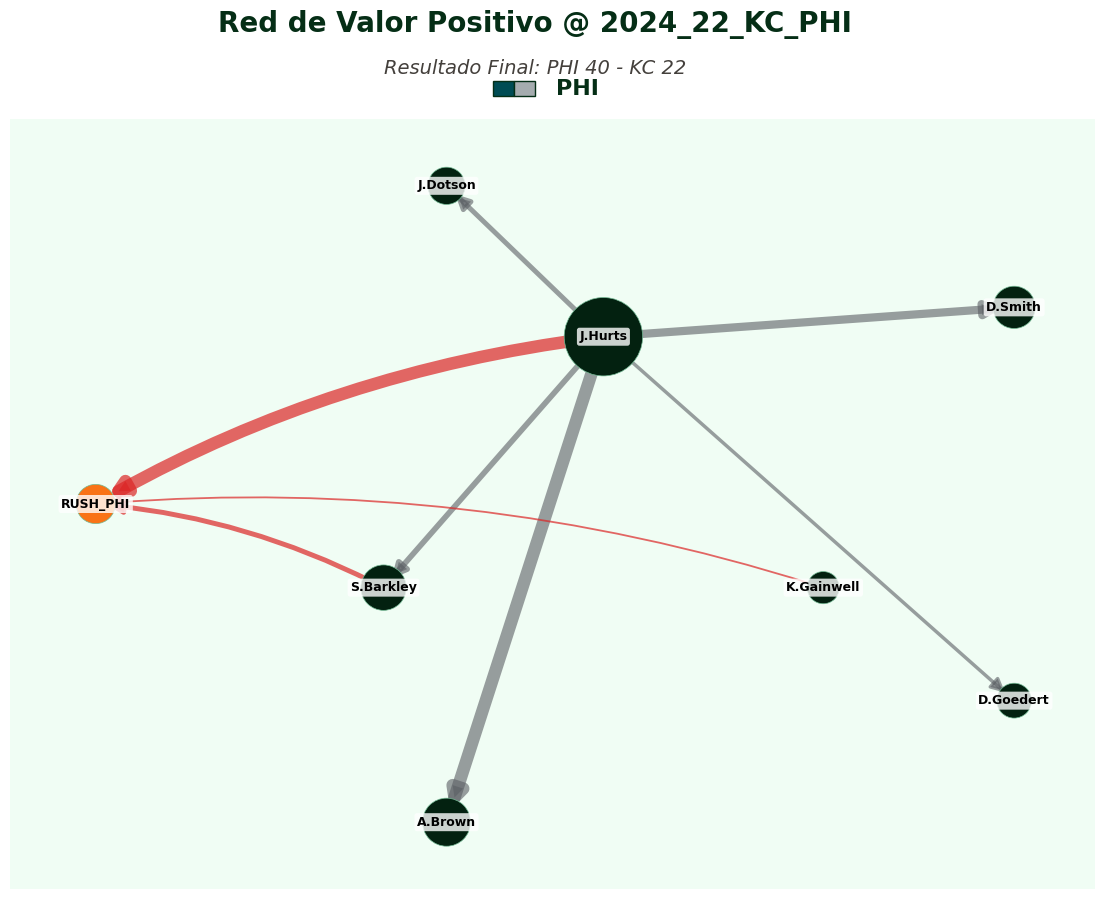

  Calculando métricas para KC...


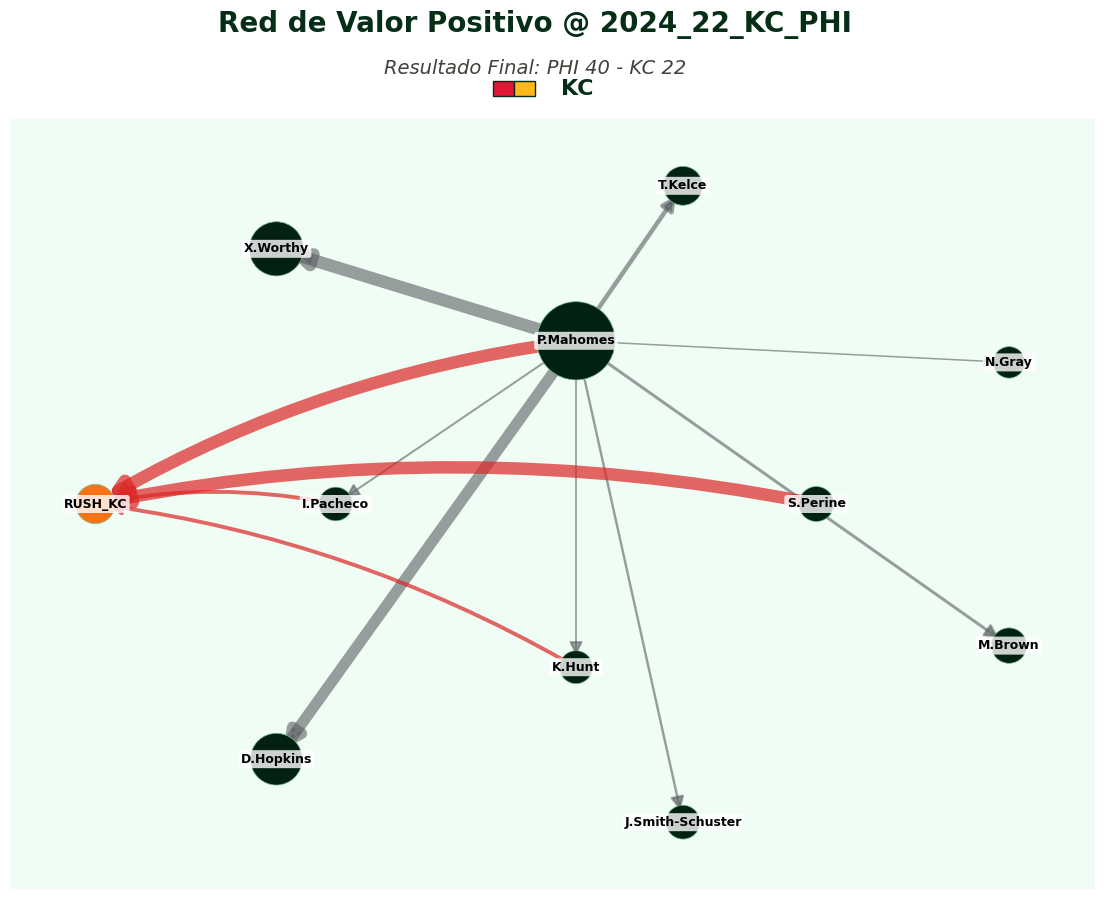

In [19]:
all_game_metrics = []

# Correremos el siguiente ciclo para calcular las métricas y generar la gráfica de la red.
# Para cada equipo del partido.
for equipo in equipos_partido:

  # Obtenemos datos del marcador que nos serán importantes para la información del gráfico.
    try:
        last_play = df_partido.iloc[-1]
        home_team = last_play['home_team']
        away_team = last_play['away_team']
        home_score = int(last_play['home_score'])
        away_score = int(last_play['away_score'])
        score_string = f"Resultado Final: {home_team} {home_score} - {away_team} {away_score}"
    except Exception as e:
        print(f"  Advertencia: No se pudo obtener el marcador final: {e}")
        score_string = "Resultado no disponible"

    # De nuestro data frame de jugadas del partido, filtramos las jugadas ofensivas del equipo en la iteración.
    df_equipo_partido = df_partido[df_partido['posteam'] == equipo]

    # De las jugadas ofensivas, filtramos solo jugadas con valor positivo para construir la red de este partido.
    # Tomamos dichas jugadas por que son las que tuvieron éxito.
    jugadas_positivas_partido = df_equipo_partido[df_equipo_partido['valor_ponderado'] > 0]

    # De las jugadas con valor positivo, extraemos las jugadas de tipo "pase" que cuenten con lanzador y receptor.
    pases_partido = jugadas_positivas_partido[
        (jugadas_positivas_partido['play_type'] == 'pass') &
        (jugadas_positivas_partido['passer_player_name'].notna()) &
        (jugadas_positivas_partido['receiver_player_name'].notna())
    ]

    # Hecho lo anterior, lo tomamos y agrupamos por pasador, receptor para obtener las conexiones.
    # Nos interesa la columna de valor ponderado y lo sumamos, para definir el peso de la arista entre ellos.
    conexiones_pases_partido = pases_partido.groupby(
        ['passer_player_name', 'receiver_player_name']
    )['valor_ponderado'].sum().reset_index()
    conexiones_pases_partido.rename(columns={'valor_ponderado': 'valor_total_conexion'}, inplace=True)

    # Ahora, los QBs muchas veces hacen jugadas individuales sin pase, por ello, definiremos un nodo especial de rush.
    # Este tipo de jugadas no son exclusivas del QB.
    # De las jugadas definidas, filtramos los rushes positivos del partido.
    rushes_partido = jugadas_positivas_partido[
        (jugadas_positivas_partido['play_type'] == 'run') &
        (jugadas_positivas_partido['rusher_player_name'].notna())
    ]
    valor_rush_partido = rushes_partido.groupby(
        ['rusher_player_name']
    )['valor_ponderado'].sum().reset_index()
    valor_rush_partido.rename(columns={'valor_ponderado': 'valor_total_conexion', 'rusher_player_name': 'jugador_origen'}, inplace=True)
    valor_rush_partido['nodo_destino'] = f"RUSH_{equipo}" # Nodo Rush.

# Construcción del Grafo
    # Definimos el grafo.
    G_partido = nx.DiGraph()

    # Definimos una variable para el nodo de rush y lo agregamos al grafo.
    NODO_RUSH_EQUIPO = f"RUSH_{equipo}"
    G_partido.add_node(NODO_RUSH_EQUIPO, type='accion_rush', team=equipo)

    # Iteramos sobre los renglones de la tabla de conexiones.
    for _, row in conexiones_pases_partido.iterrows():
        # Tomamos el pasador y receptor, así como el valor del peso.
        passer = row['passer_player_name']
        receiver = row['receiver_player_name']
        weight = row.get('valor_total_conexion', 0)
        # Creamos nodos para el pasador, receptor y una arista para su conexión o enlace.
        G_partido.add_edge(passer, receiver,
                           weight=weight, type='pass')
        G_partido.add_node(passer, type='jugador', team=equipo)
        G_partido.add_node(receiver, type='jugador', team=equipo)

    # Ahora iteramos para los renglones de jugadas de rush.
    for _, row in valor_rush_partido.iterrows():
        # Tomamos el jugador que hizo el rush, así como el peso de la jugada. Como nodo destino es simplemente el que ya creamos.
        rusher = row['jugador_origen']
        weight = row.get('valor_total_conexion', 0)
        rush_node_destino = row['nodo_destino']
        # Si no existe el nodo para dicho jugador, lo agregamos.
        if not G_partido.has_node(rusher):
            G_partido.add_node(rusher, type='jugador', team=equipo)
        # Si ya existe, agregamos la arista que une al jugador con el nodo rush.
        G_partido.add_edge(rusher, rush_node_destino,
                           weight=weight, type='rush')

# Cálculo y Almacenamiento de Métricas
    # Nos aseguramos de que el grafo tenga nodos y aristas.
    if G_partido.number_of_nodes() > 1 and G_partido.number_of_edges() > 0:
        # Solo se agregó para detectar errores en la ejecución.
        print(f"  Calculando métricas para {equipo}...")
        try:
            # Calculamos las métricas que nos son de interés.
            # Métricas Básicas (Grados y Fuerzas)
            in_strength = dict(G_partido.in_degree(weight='weight'))
            out_strength = dict(G_partido.out_degree(weight='weight'))
            in_degree = dict(G_partido.in_degree())
            out_degree = dict(G_partido.out_degree())
            # PageRank.
            pagerank = nx.pagerank(G_partido, weight='weight', alpha=0.9)
            # Betweenness Centrality.
            betweenness = nx.betweenness_centrality(G_partido, weight='weight', normalized=True)
            # HITS (Hubs y Autoridades)
            hubs, authorities = nx.hits(G_partido, max_iter=500, tol=1.0e-4)
            # Densidad
            density = nx.density(G_partido)

            # Guardamos las métricas del partido
            for node, data in G_partido.nodes(data=True):
                node_id = node
                # Solo guardamos métricas de jugadores reales, es decir, no para el nodo rush.
                if data.get('type') == 'jugador':
                    all_game_metrics.append({
                        # Usar game_ids[0] ya que es solo el primer partido
                        'game_id': game_ids[0],
                        'equipo': equipo,
                        'jugador': node_id,
                        'in_strength_partido': in_strength.get(node_id, 0),
                        'out_strength_partido': out_strength.get(node_id, 0),
                        'in_degree_partido': in_degree.get(node_id, 0),
                        'out_degree_partido': out_degree.get(node_id, 0),
                        'pagerank_partido': pagerank.get(node_id, 0),
                        'betweenness_partido': betweenness.get(node_id, 0),
                        'hub_score_partido': hubs.get(node_id, 0),
                        'authority_score_partido': authorities.get(node_id, 0),
                        'densidad_grafo_partido': density
                    })
        except Exception as e:
            # Para capturar errores generales en el cálculo de métricas.
            print(f"  Error general calculando métricas para {equipo}: {e}")
    else:
        print(f"  Red vacía o sin aristas para {equipo}. No se calculan métricas.")


# Dibujo del gráfico.
    # Comprobamos si las variables de métricas existen.
    if G_partido.number_of_nodes() > 1 and 'in_strength' in locals() and 'out_strength' in locals():
        # Definimos fig y ax.
        fig, ax = plt.subplots(figsize=(14, 10))

        # --- PALETA MODO BOSQUE ---
        fondo_color = '#F0FDF4' # Fondo Menta muy claro
        titulo_color = '#052e16' # Verde Bosque oscuro
        subtitulo_color = '#44403c' # Gris cálido
        nodo_jugador_color = '#032110' # Verde Bosque oscuro
        nodo_rush_color = '#f97316' # Naranja brillante
        edge_pass_color = '#5A5E63' # Gris medio
        edge_rush_color = '#dc2626' # Rojo
        label_text_color = '#000000' # Texto negro
        bbox_color = '#FFFFFF'
        borde_nodo_color = '#73BA94' # Borde blanco
        borde_bandera_color = '#052e16'

        #Color de fondo.
        ax.scatter([0], [0], s=10000000000, c=fondo_color, alpha=1, zorder=0)

        # Preparamos los atributos.
        # Tamaño de los nodos usando la fuerza de entrada y de salida.
        node_sizes = [ (in_strength.get(n, 0) + out_strength.get(n, 0)) * 20 + 500 if G_partido.nodes[n].get('type') == 'jugador' else 800 for n in G_partido.nodes()]
        # Colores de los nodos que hagan buen contraste con el fondo.
        node_colors = [nodo_jugador_color if G_partido.nodes[n].get('type') == 'jugador' else nodo_rush_color for n in G_partido.nodes()]

        # Layout de la red.
        # Separamos los qbs de otros jugadores, pues son la fuente principal de aristas.
        qbs = [n for n in G_partido.nodes() if out_degree.get(n, 0) > 0 and G_partido.nodes[n].get('type') == 'jugador']
        others = [n for n in G_partido.nodes() if n not in qbs]
        pos = None
        # Usamos un shell_layout y si no se puede, nos quedamos con spring_layout.
        if qbs and others:
             try:
                 pos = nx.shell_layout(G_partido, [qbs, others])
             except Exception as e_layout:
                 print(f"    Advertencia: Falló shell_layout ({e_layout}), usando spring_layout.")
                 pos = nx.spring_layout(G_partido, seed=42) # Seed para reproducibilidad
        else:
             pos = nx.spring_layout(G_partido, seed=42)

        # Separar aristas en pases y rush.
        pass_edges = [(u,v) for u,v,d in G_partido.edges(data=True) if d.get('type')=='pass']
        rush_edges = [(u,v) for u,v,d in G_partido.edges(data=True) if d.get('type')=='rush']
        # Tomamos los pesos de cara arista.
        pass_weights = [G_partido[u][v].get('weight', 0) for u,v in pass_edges]
        rush_weights = [G_partido[u][v].get('weight', 0) for u,v in rush_edges]
        # Tomamos los valores maximos de los pesos de pase y rush.
        max_p_w = max(pass_weights) if pass_weights else 1
        max_r_w = max(rush_weights) if rush_weights else 1
        # Asegurar que el divisor no sea 0. En dado caso, tomaremos 1 como su valor.
        if max_p_w == 0: max_p_w = 1
        if max_r_w == 0: max_r_w = 1
        # Definimos el ancho de cada arista.
        pass_widths = [ (w/max_p_w)*8 + 1 for w in pass_weights ]
        rush_widths = [ (w/max_r_w)*8 + 1 for w in rush_weights ]

        # Posición de la etiqueta del nombre.
        label_pos = {}
        y_offset = 0.0 # <-- Sin desplazamiento, como pediste
        for node, (x, y) in pos.items():
            label_pos[node] = (x, y + y_offset)

        # Caja para la etiqueta del nombre del jugador.
        label_bbox = {
            "facecolor": bbox_color,
            "edgecolor": "none",
            "alpha": 0.8,
            "boxstyle": "round,pad=0.2"
        }

        # Dibujamos los nodos de G.
        nx.draw_networkx_nodes(G_partido, pos, ax=ax, node_size=node_sizes, node_color=node_colors, edgecolors=borde_nodo_color, linewidths=0.5, alpha=1)

        # Dibujamos el nombre de cada jugador.
        labels_dark_bg = {n:n for n,c in zip(G_partido.nodes(), node_colors) if c == nodo_jugador_color}
        labels_light_bg = {n:n for n,c in zip(G_partido.nodes(), node_colors) if c != nodo_jugador_color}
        nx.draw_networkx_labels(G_partido, label_pos, ax=ax, labels=labels_light_bg, font_size=9, font_color = label_text_color, bbox=label_bbox, font_weight='bold')
        nx.draw_networkx_labels(G_partido, label_pos, ax=ax, labels=labels_dark_bg, font_size=9, font_color = 'black', bbox=label_bbox, font_weight='bold') # Texto blanco

        # Dibujamos las aristas de pases.
        nx.draw_networkx_edges(G_partido, pos, ax=ax, edgelist=pass_edges, width=pass_widths, edge_color=edge_pass_color, alpha=0.6, arrowsize=20)

        # Dibujamos las aristas de rush.
        nx.draw_networkx_edges(G_partido, pos, ax=ax, edgelist=rush_edges, width=rush_widths, edge_color=edge_rush_color, alpha=0.7, arrowsize=20, connectionstyle='arc3, rad=0.1')


        # Encabezado de la gráfica. Titulos y subtitulos.
        # Colores y fuente
        color_titulo_principal = titulo_color
        color_subtitulo = subtitulo_color
        fuente = 'DejaVu Sans'
        # Título Principal (Partido)
        fig.text(
            0.5, 0.96, # Posición X, Y
            f"Red de Valor Positivo @ {game_ids[-1]}",
            ha='center', va='bottom', fontsize=20, fontname=fuente,
            weight='bold', color=color_titulo_principal
        )
        # Subtítulo (Marcador)
        if 'score_string' in locals():
            fig.text(
                0.5, 0.94, score_string,
                ha='center', va='top', fontsize=14, fontname=fuente,
                style='italic', color=color_subtitulo
            )
        # Título del Equipo con bandera.
        team_y_pos = 0.91
        fig.text(
            0.53, team_y_pos,
            equipo,
            ha='center', va='center',
            fontname=fuente, weight='bold', fontsize=16, color=color_titulo_principal
        )
        # Bandera del equipo.
        # Tamaño de la bandera y la centramos verticalmente.
        swatch_size = 0.015
        patch_y_pos = team_y_pos - (swatch_size / 2)
        # Obtener colores del equipo para la bandera.
        primary_color, secondary_color = NFL_TEAM_COLORS_PALETTE.get(equipo, DEFAULT_COLORS)
        # Posición de la bandera.
        flag_start_x = 0.47
        # Bandera indicadora del equipo.
        fig.patches.extend([
            plt.Rectangle(
                (flag_start_x, patch_y_pos),
                swatch_size, swatch_size, # width, height
                facecolor=primary_color,
                edgecolor=borde_bandera_color,
                transform=fig.transFigure, figure=fig
            )
        ])
        fig.patches.extend([
            plt.Rectangle(
                (flag_start_x + swatch_size, patch_y_pos), # Se coloca justo después del primario
                swatch_size, swatch_size, # width, height
                facecolor=secondary_color,
                edgecolor=borde_bandera_color,
                transform=fig.transFigure, figure=fig
            )
        ])
        # Quitamos los ejes.
        plt.axis('off')
        # Mostramos el gráfico.
        plt.show()
    else:
        print(f"  No se grafica la red para {equipo} (vacía o sin métricas calculadas).")

In [20]:
df_game_metrics = pd.DataFrame(all_game_metrics)
df_game_metrics

,game_id,equipo,jugador,in_strength_partido,out_strength_partido,in_degree_partido,out_degree_partido,pagerank_partido,betweenness_partido,hub_score_partido,authority_score_partido,densidad_grafo_partido
0,2024_01_ARI_BUF,PHI,J.Hurts,0.000000,134.333333,0,6,0.092761,0.000000,0.837357,-0.000000,0.142857
1,2024_01_ARI_BUF,PHI,A.Brown,34.833333,0.000000,1,0,0.114409,0.000000,-0.000000,0.254258,0.142857
2,2024_01_ARI_BUF,PHI,D.Goedert,6.500000,0.000000,1,0,0.096800,0.000000,-0.000000,0.047445,0.142857
3,2024_01_ARI_BUF,PHI,D.Smith,21.333333,0.000000,1,0,0.106019,0.000000,-0.000000,0.155718,0.142857
4,2024_01_ARI_BUF,PHI,J.Dotson,11.000000,0.000000,1,0,0.099597,0.000000,-0.000000,0.080292,0.142857
5,2024_01_ARI_BUF,PHI,S.Barkley,13.333333,15.166667,1,1,0.101047,0.023810,0.145103,0.097324,0.142857
6,2024_01_ARI_BUF,PHI,K.Gainwell,0.000000,1.833333,0,1,0.092761,0.000000,0.017540,-0.000000,0.142857
7,2024_01_ARI_BUF,KC,P.Mahomes,0.000000,133.666667,0,9,0.068365,0.000000,0.986932,-0.000000,0.109091
8,2024_01_ARI_BUF,KC,D.Hopkins,44.500000,0.000000,1,0,0.088850,0.000000,-0.000000,0.332751,0.109091
9,2024_01_ARI_BUF,KC,I.Pacheco,2.833333,1.500000,1,1,0.069670,0.000000,0.002028,0.021186,0.109091


La idea es replicar este análisis para cada uno de los partidos, iterando sobre el id del partido. Podemos incluso comparar las métricas con multiplicador de presión y sin multiplicador de presión, para determinar si existe alguna diferencia.

Para quitar la parte del multiplicador, simplemente nos basta con hacer `jugadas_ofensivas['valor_ponderado'] = jugadas_ofensivas['valor_base']`

Posterior a ello, se buscará valorar o rankear los jugadores, así como hacer comparaciones en medida de lo posible.

Una vez hecho esto, iteremos sobre todos los equipos y construyamos una red por equipo por partido, y finalmente, calculemos las métricas globales.

### Obtención de métricas para todos los partidos (sin generar los gráficos)

#### Jugadas con presión.

In [21]:
# Jugadas con presión y sin graficar.
jugadas_ofensivas['valor_ponderado'] = jugadas_ofensivas['valor_base'] * jugadas_ofensivas['multiplicador_presion']

all_game_metrics = []

# Creamos una carpeta para almacenar todos los grafos y no mostrarlos en pantalla.
output_folder_graphs = "grafos_por_equipo_2024_con_presion"
if not os.path.exists(output_folder_graphs):
    os.makedirs(output_folder_graphs)
    print(f"Carpeta '{output_folder_graphs}' creada para guardar los grafos.")

# Obtener lista de partidos. Sobre ellos iteraremos el ejemplo anterior.
game_ids = jugadas_ofensivas['game_id'].unique()
total_games = len(game_ids)
print(f"Iniciando análisis por partido para {total_games} juegos...")

# Ciclo sobre los id_games.
for i, game_id in enumerate(game_ids):
    # Usar replace para evitar caracteres inválidos en nombres de archivo.
    safe_game_id = game_id.replace('/', '_').replace('\\', '_')
    print(f"Procesando Partido {i+1}/{total_games}: {game_id}")

    # Filtrar jugadas solo de este partido
    df_partido = jugadas_ofensivas[jugadas_ofensivas['game_id'] == game_id]

    # Identificar los equipos que jugaron
    equipos_partido = df_partido['posteam'].dropna().unique()

    # Iteramos para cada equipo del partido.
    for equipo in equipos_partido:
        # Filtrar jugadas ofensivas de cada equipo.
        df_equipo_partido = df_partido[df_partido['posteam'] == equipo]

        # Filtrar solo jugadas positivas para construir la red de este partido, son las que tuvieron éxito.
        jugadas_positivas_partido = df_equipo_partido[df_equipo_partido['valor_ponderado'] > 0]

        # Agregar Pases Positivos del Partido, aquellos que tienen lanzador y receptor.
        pases_partido = jugadas_positivas_partido[
            (jugadas_positivas_partido['play_type'] == 'pass') &
            (jugadas_positivas_partido['passer_player_name'].notna()) &
            (jugadas_positivas_partido['receiver_player_name'].notna())
        ]
        # Analizamos dichas conexiones, agrupando por pasador y receptor.
        # Tomamos la columna de valor ponderado y lo sumamos, para definir el peso de la arista entre ellos.
        conexiones_pases_partido = pases_partido.groupby(
            ['passer_player_name', 'receiver_player_name']
        )['valor_ponderado'].sum().reset_index()
        conexiones_pases_partido.rename(columns={'valor_ponderado': 'valor_total_conexion'}, inplace=True)

        # Agregar Rushes Positivos del Partido
        rushes_partido = jugadas_positivas_partido[
            (jugadas_positivas_partido['play_type'] == 'run') &
            (jugadas_positivas_partido['rusher_player_name'].notna())
        ]
        valor_rush_partido = rushes_partido.groupby(
            ['rusher_player_name']
        )['valor_ponderado'].sum().reset_index()
        valor_rush_partido.rename(columns={'valor_ponderado': 'valor_total_conexion', 'rusher_player_name': 'jugador_origen'}, inplace=True)
        valor_rush_partido['nodo_destino'] = f"RUSH_{equipo}" # Nodo Rush.

        # Construcción del Grafo
        G_partido = nx.DiGraph()
        NODO_RUSH_EQUIPO = f"RUSH_{equipo}"
        G_partido.add_node(NODO_RUSH_EQUIPO, type='accion_rush', team=equipo)

        for _, row in conexiones_pases_partido.iterrows():
            passer = row['passer_player_name']
            receiver = row['receiver_player_name']
            weight = row.get('valor_total_conexion', 0)
            G_partido.add_edge(passer, receiver,
                               weight=weight, type='pass')
            G_partido.add_node(passer, type='jugador', team=equipo)
            G_partido.add_node(receiver, type='jugador', team=equipo)


        for _, row in valor_rush_partido.iterrows():
            rusher = row['jugador_origen']
            weight = row.get('valor_total_conexion', 0)
            rush_node_destino = row['nodo_destino']
            if not G_partido.has_node(rusher):
                G_partido.add_node(rusher, type='jugador', team=equipo)
            G_partido.add_edge(rusher, rush_node_destino,
                               weight=weight, type='rush')

        if G_partido.number_of_edges() > 0:
            for u, v, data in G_partido.edges(data=True):
                # data['weight'] es el 'valor_total_conexion'
                peso = data.get('weight', 0)

                # Como filtramos por valor_ponderado > 0, el peso siempre será positivo
                # Añadimos un valor muy pequeño (epsilon) por si acaso algo es 0
                G_partido.edges[u, v]['costo'] = 1.0 / peso

        # Cálculo y Almacenamiento de Métricas.
        # Nos aseguramos de que el grafo tenga nodos y aristas.
        if G_partido.number_of_nodes() > 1 and G_partido.number_of_edges() > 0:
            print(f"  Calculando métricas para {equipo}...")
            # Declarar métricas fuera del try para que existan
            in_strength, out_strength, in_degree, out_degree = {}, {}, {}, {}
            pagerank, betweenness, hubs, authorities, density = {}, {}, {}, {}, 0
            try:
                # Métricas Básicas (Grados y Fuerzas)
                in_strength = dict(G_partido.in_degree(weight='weight'))
                out_strength = dict(G_partido.out_degree(weight='weight'))
                in_degree = dict(G_partido.in_degree())
                out_degree = dict(G_partido.out_degree())

                # PageRank.
                pagerank = nx.pagerank(G_partido, weight='weight', alpha=0.9)

                # Betweenness Centrality.
                betweenness = nx.betweenness_centrality(G_partido, weight='costo', normalized=True)

                # HITS (Hubs y Autoridades)
                try:
                    hubs, authorities = nx.hits(G_partido, max_iter=500, tol=1.0e-4)
                except Exception as e_hits:
                     print(f"    Advertencia: No se pudo calcular HITS: {e_hits}")
                     hubs = {node: 0 for node in G_partido.nodes()}
                     authorities = {node: 0 for node in G_partido.nodes()}

                # Densidad
                density = nx.density(G_partido)

                # Percolación.
                try:
                    # 1. Definir los estados de percolación
                    # Por defecto, todos tienen un valor bajo (0.1)
                    percolation_states = {n: 0.1 for n in G_partido.nodes()}

                    # 2. Identificar al QB (el que tiene más out_degree) y darle valor alto (1.0)
                    # Esto simula que el juego "nace" de él.
                    # (Ordenamos nodos por out_degree y tomamos el mayor)
                    posible_qb = max(dict(G_partido.out_degree(weight='weight')).items(), key=lambda x: x[1])[0]

                    # Asegurarnos de que sea un jugador y no el nodo RUSH
                    if G_partido.nodes[posible_qb].get('type') == 'jugador':
                         percolation_states[posible_qb] = 1.0

                    # 3. Calcular Percolación usando 'states'
                    percolation = nx.percolation_centrality(
                        G_partido,
                        weight='costo',
                        states=percolation_states
                    )
                except Exception as e_perc:
                    percolation = {node: 0 for node in G_partido.nodes()}

                # Guardar métricas del partido
                for node, data in G_partido.nodes(data=True):
                    node_id = node
                    # Solo guardamos métricas de jugadores reales
                    if data.get('type') == 'jugador':
                        valor_rush_jugador = sum([d['weight'] for u, v, d in G_partido.out_edges(node_id, data=True) if v.startswith('RUSH_')])
                        all_game_metrics.append({
                            'game_id': game_id,
                            'equipo': equipo,
                            'jugador': node_id,
                            'in_strength_partido': in_strength.get(node_id, 0),
                            'out_strength_partido': out_strength.get(node_id, 0),
                            'in_degree_partido': in_degree.get(node_id, 0),
                            'out_degree_partido': out_degree.get(node_id, 0),
                            'rush_strength_partido': valor_rush_jugador,
                            'pagerank_partido': pagerank.get(node_id, 0),
                            'betweenness_partido': betweenness.get(node_id, 0),
                            'hub_score_partido': hubs.get(node_id, 0),
                            'authority_score_partido': authorities.get(node_id, 0),
                            'percolation_partido': percolation.get(node_id, 0),
                            'densidad_grafo_partido': density
                        })

            except Exception as e:
                # Captura errores generales en el cálculo de métricas
                print(f"  Error calculando métricas para {equipo} en {game_id}: {e}")
        else:
            print(f"  Red vacía o sin aristas para {equipo}. No se calculan métricas.")

print("\n--- Análisis por partido completado ---")

# Agregamos las métricas y las guardamos como un csv.

print("\nCreando DataFrame de métricas por partido...")
df_game_metrics = pd.DataFrame(all_game_metrics)
csv_filename_raw = "metricas_por_partido_con_presion_2024.csv"
df_game_metrics.to_csv(csv_filename_raw, index=False, encoding='utf-8-sig')

print(f"\n Métricas por partido guardadas en '{csv_filename_raw}'")

print("\n Proceso Finalizado")
print(f"Se generaron las métricas para {len(df_game_metrics)} registros de jugadores")

Carpeta 'grafos_por_equipo_2024_con_presion' creada para guardar los grafos.
Iniciando análisis por partido para 285 juegos...
Procesando Partido 1/285: 2024_01_ARI_BUF
  Calculando métricas para ARI...
  Calculando métricas para BUF...
Procesando Partido 2/285: 2024_01_BAL_KC
  Calculando métricas para BAL...
  Calculando métricas para KC...
Procesando Partido 3/285: 2024_01_CAR_NO
  Calculando métricas para NO...
  Calculando métricas para CAR...
Procesando Partido 4/285: 2024_01_DAL_CLE
  Calculando métricas para DAL...
  Calculando métricas para CLE...
Procesando Partido 5/285: 2024_01_DEN_SEA
  Calculando métricas para SEA...
  Calculando métricas para DEN...
Procesando Partido 6/285: 2024_01_GB_PHI
  Calculando métricas para GB...
  Calculando métricas para PHI...
Procesando Partido 7/285: 2024_01_HOU_IND
  Calculando métricas para IND...
  Calculando métricas para HOU...
Procesando Partido 8/285: 2024_01_JAX_MIA
  Calculando métricas para MIA...
  Calculando métricas para JAX...

#### Jugadas sin presión.

In [22]:
# Para jugadas sin presión y sin graficar.
jugadas_ofensivas['valor_ponderado'] = jugadas_ofensivas['valor_base']

all_game_metrics = []

# Creamos una carpeta para almacenar todos los grafos y no mostrarlos en pantalla.
output_folder_graphs = "grafos_por_equipo_2024_sin_presion"
if not os.path.exists(output_folder_graphs):
    os.makedirs(output_folder_graphs)
    print(f"Carpeta '{output_folder_graphs}' creada para guardar los grafos.")

# Obtener lista de partidos. Sobre ellos iteraremos el ejemplo anterior.
game_ids = jugadas_ofensivas['game_id'].unique()
total_games = len(game_ids)
print(f"Iniciando análisis por partido para {total_games} juegos...")

# Ciclo sobre los id_games.
for i, game_id in enumerate(game_ids):
    # Usar replace para evitar caracteres inválidos en nombres de archivo.
    safe_game_id = game_id.replace('/', '_').replace('\\', '_')
    print(f"Procesando Partido {i+1}/{total_games}: {game_id}")

    # Filtrar jugadas solo de este partido
    df_partido = jugadas_ofensivas[jugadas_ofensivas['game_id'] == game_id]

    # Identificar los equipos que jugaron
    equipos_partido = df_partido['posteam'].dropna().unique()

    # Iteramos para cada equipo del partido.
    for equipo in equipos_partido:
        # Filtrar jugadas ofensivas de cada equipo.
        df_equipo_partido = df_partido[df_partido['posteam'] == equipo]

        # Filtrar solo jugadas positivas para construir la red de este partido, son las que tuvieron éxito.
        jugadas_positivas_partido = df_equipo_partido[df_equipo_partido['valor_ponderado'] > 0]

        # Agregar Pases Positivos del Partido, aquellos que tienen lanzador y receptor.
        pases_partido = jugadas_positivas_partido[
            (jugadas_positivas_partido['play_type'] == 'pass') &
            (jugadas_positivas_partido['passer_player_name'].notna()) &
            (jugadas_positivas_partido['receiver_player_name'].notna())
        ]
        # Analizamos dichas conexiones, agrupando por pasador y receptor.
        # Tomamos la columna de valor ponderado y lo sumamos, para definir el peso de la arista entre ellos.
        conexiones_pases_partido = pases_partido.groupby(
            ['passer_player_name', 'receiver_player_name']
        )['valor_ponderado'].sum().reset_index()
        conexiones_pases_partido.rename(columns={'valor_ponderado': 'valor_total_conexion'}, inplace=True)

        # Agregar Rushes Positivos del Partido
        rushes_partido = jugadas_positivas_partido[
            (jugadas_positivas_partido['play_type'] == 'run') &
            (jugadas_positivas_partido['rusher_player_name'].notna())
        ]
        valor_rush_partido = rushes_partido.groupby(
            ['rusher_player_name']
        )['valor_ponderado'].sum().reset_index()
        valor_rush_partido.rename(columns={'valor_ponderado': 'valor_total_conexion', 'rusher_player_name': 'jugador_origen'}, inplace=True)
        valor_rush_partido['nodo_destino'] = f"RUSH_{equipo}" # Nodo Rush.

        # Construcción del Grafo
        G_partido = nx.DiGraph()
        NODO_RUSH_EQUIPO = f"RUSH_{equipo}"
        G_partido.add_node(NODO_RUSH_EQUIPO, type='accion_rush', team=equipo)

        for _, row in conexiones_pases_partido.iterrows():
            passer = row['passer_player_name']
            receiver = row['receiver_player_name']
            weight = row.get('valor_total_conexion', 0)
            G_partido.add_edge(passer, receiver,
                               weight=weight, type='pass')
            G_partido.add_node(passer, type='jugador', team=equipo)
            G_partido.add_node(receiver, type='jugador', team=equipo)


        for _, row in valor_rush_partido.iterrows():
            rusher = row['jugador_origen']
            weight = row.get('valor_total_conexion', 0)
            rush_node_destino = row['nodo_destino']
            if not G_partido.has_node(rusher):
                G_partido.add_node(rusher, type='jugador', team=equipo)
            G_partido.add_edge(rusher, rush_node_destino,
                               weight=weight, type='rush')
        if G_partido.number_of_edges() > 0:
            for u, v, data in G_partido.edges(data=True):
                # data['weight'] es el 'valor_total_conexion'
                peso = data.get('weight', 0)

                # Como filtramos por valor_ponderado > 0, el peso siempre será positivo
                # Añadimos un valor muy pequeño (epsilon) por si acaso algo es 0
                G_partido.edges[u, v]['costo'] = 1.0 / peso

        # Cálculo y Almacenamiento de Métricas.
        # Nos aseguramos de que el grafo tenga nodos y aristas.
        if G_partido.number_of_nodes() > 1 and G_partido.number_of_edges() > 0:
            print(f"  Calculando métricas para {equipo}...")
            # Declarar métricas fuera del try para que existan
            in_strength, out_strength, in_degree, out_degree = {}, {}, {}, {}
            pagerank, betweenness, hubs, authorities, density = {}, {}, {}, {}, 0
            try:
                # Métricas Básicas (Grados y Fuerzas)
                in_strength = dict(G_partido.in_degree(weight='weight'))
                out_strength = dict(G_partido.out_degree(weight='weight'))
                in_degree = dict(G_partido.in_degree())
                out_degree = dict(G_partido.out_degree())

                # PageRank.
                pagerank = nx.pagerank(G_partido, weight='weight', alpha=0.9)

                # Betweenness Centrality.
                betweenness = nx.betweenness_centrality(G_partido, weight='costo', normalized=True)

                # HITS (Hubs y Autoridades)
                try:
                    hubs, authorities = nx.hits(G_partido, max_iter=500, tol=1.0e-4)
                except Exception as e_hits:
                     print(f"    Advertencia: No se pudo calcular HITS: {e_hits}")
                     hubs = {node: 0 for node in G_partido.nodes()}
                     authorities = {node: 0 for node in G_partido.nodes()}

                # Densidad
                density = nx.density(G_partido)

                # Percolación.
                try:
                    # 1. Definir los estados de percolación
                    # Por defecto, todos tienen un valor bajo (0.1)
                    percolation_states = {n: 0.1 for n in G_partido.nodes()}

                    # 2. Identificar al QB (el que tiene más out_degree) y darle valor alto (1.0)
                    # Esto simula que el juego "nace" de él.
                    # (Ordenamos nodos por out_degree y tomamos el mayor)
                    posible_qb = max(dict(G_partido.out_degree(weight='weight')).items(), key=lambda x: x[1])[0]

                    # Asegurarnos de que sea un jugador y no el nodo RUSH
                    if G_partido.nodes[posible_qb].get('type') == 'jugador':
                         percolation_states[posible_qb] = 1.0

                    # 3. Calcular Percolación usando 'states'
                    percolation = nx.percolation_centrality(
                        G_partido,
                        weight='costo',
                        states=percolation_states
                    )
                except Exception as e_perc:
                    percolation = {node: 0 for node in G_partido.nodes()}


                # Guardar métricas del partido
                for node, data in G_partido.nodes(data=True):
                    node_id = node
                    # Solo guardamos métricas de jugadores reales
                    if data.get('type') == 'jugador':
                        valor_rush_jugador = sum([d['weight'] for u, v, d in G_partido.out_edges(node_id, data=True) if v.startswith('RUSH_')])
                        all_game_metrics.append({
                            'game_id': game_id,
                            'equipo': equipo,
                            'jugador': node_id,
                            'in_strength_partido': in_strength.get(node_id, 0),
                            'out_strength_partido': out_strength.get(node_id, 0),
                            'in_degree_partido': in_degree.get(node_id, 0),
                            'out_degree_partido': out_degree.get(node_id, 0),
                            'rush_strength_partido': valor_rush_jugador,
                            'pagerank_partido': pagerank.get(node_id, 0),
                            'betweenness_partido': betweenness.get(node_id, 0),
                            'hub_score_partido': hubs.get(node_id, 0),
                            'authority_score_partido': authorities.get(node_id, 0),
                            'percolation_partido': percolation.get(node_id, 0),
                            'densidad_grafo_partido': density
                        })

            except Exception as e:
                # Captura errores generales en el cálculo de métricas
                print(f"  Error calculando métricas para {equipo} en {game_id}: {e}")
        else:
            print(f"  Red vacía o sin aristas para {equipo}. No se calculan métricas.")

print("\n--- Análisis por partido completado ---")

# Agregamos las métricas y las guardamos como un csv.

print("\nCreando DataFrame de métricas por partido...")
df_game_metrics = pd.DataFrame(all_game_metrics)
csv_filename_raw = "metricas_por_partido_sin_presion_2024.csv"
df_game_metrics.to_csv(csv_filename_raw, index=False, encoding='utf-8-sig')

print(f"\n Métricas por partido guardadas en '{csv_filename_raw}'")

print("\n Proceso Finalizado")
print(f"Se generaron las métricas para {len(df_game_metrics)} registros de jugadores")

Carpeta 'grafos_por_equipo_2024_sin_presion' creada para guardar los grafos.
Iniciando análisis por partido para 285 juegos...
Procesando Partido 1/285: 2024_01_ARI_BUF
  Calculando métricas para ARI...
  Calculando métricas para BUF...
Procesando Partido 2/285: 2024_01_BAL_KC
  Calculando métricas para BAL...
  Calculando métricas para KC...
Procesando Partido 3/285: 2024_01_CAR_NO
  Calculando métricas para NO...
  Calculando métricas para CAR...
Procesando Partido 4/285: 2024_01_DAL_CLE
  Calculando métricas para DAL...
  Calculando métricas para CLE...
Procesando Partido 5/285: 2024_01_DEN_SEA
  Calculando métricas para SEA...
  Calculando métricas para DEN...
Procesando Partido 6/285: 2024_01_GB_PHI
  Calculando métricas para GB...
  Calculando métricas para PHI...
Procesando Partido 7/285: 2024_01_HOU_IND
  Calculando métricas para IND...
  Calculando métricas para HOU...
Procesando Partido 8/285: 2024_01_JAX_MIA
  Calculando métricas para MIA...
  Calculando métricas para JAX...

### Análisis de metricas obtenidas.

Cargamos los data frames con los datos.

In [23]:
mpp_sp = pd.read_csv('metricas_por_partido_sin_presion_2024.csv')
mpp_cp = pd.read_csv('metricas_por_partido_con_presion_2024.csv')

Función auxiliar para generar los gráficos.

In [24]:
# Funciones auxiliares para graficar los rankings.

def graficar_ranking(df, col_valor, col_nombre, col_equipo, titulo, color_base, etiqueta_eje_x):
    top_15 = df.head(15).copy()

    ranks = range(1, len(top_15) + 1)
    top_15['etiqueta_completa'] = [
        f"{rank}. {nombre} ({equipo})"
        for rank, nombre, equipo in zip(ranks, top_15[col_nombre], top_15[col_equipo])
    ]

    plt.figure(figsize=(5, 4))

    ax = sns.barplot(
        data=top_15,
        x=col_valor,
        y='etiqueta_completa',
        color=color_base,
        edgecolor='black'
    )

    plt.title(titulo, fontsize=18, fontweight='bold', pad=20)
    plt.xlabel(etiqueta_eje_x, fontsize=14)
    plt.ylabel('Jugador', fontsize=14)

    for i, container in enumerate(ax.containers):
        val_ejemplo = top_15[col_valor].iloc[0]
        fmt = '%.3f' if val_ejemplo < 1 else '%.1f'

        ax.bar_label(container, fmt=fmt, padding=5, fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

def graficar_ranking_equipos(df, col_valor, col_equipo, titulo, color_base, etiqueta_eje_x):
    top_equipos = df.head(15).copy()

    ranks = range(1, len(top_equipos) + 1)
    top_equipos['equipo_rank'] = [
        f"{rank}. {equipo}"
        for rank, equipo in zip(ranks, top_equipos[col_equipo])
    ]

    plt.figure(figsize=(5, 4))

    ax = sns.barplot(
        data=top_equipos,
        x=col_valor,
        y='equipo_rank',
        color=color_base,
        edgecolor='black'
    )

    plt.title(titulo, fontsize=18, fontweight='bold', pad=20)
    plt.xlabel(etiqueta_eje_x, fontsize=14)
    plt.ylabel('Equipo', fontsize=14)

    for i, container in enumerate(ax.containers):
        ax.bar_label(container, fmt='%.1f', padding=5, fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

Análisis de QBs

In [25]:
qb_ranking_sp = mpp_sp.groupby('jugador').agg(
    equipo=('equipo', 'last'),
    valor_generado_TOTAL=('out_strength_partido', 'sum')
)
qb_ranking_sp_sorted = qb_ranking_sp.sort_values(by='valor_generado_TOTAL', ascending=False)
qb_ranking_sp_sorted = qb_ranking_sp_sorted.reset_index()
qb_ranking_sp_sorted.index = qb_ranking_sp_sorted.index + 1
qb_ranking_sp_sorted.index.name = 'Rank'


qb_ranking_cp = mpp_cp.groupby('jugador').agg(
    equipo=('equipo', 'last'),
    valor_generado_TOTAL=('out_strength_partido', 'sum')
)
qb_ranking_cp_sorted = qb_ranking_cp.sort_values(by='valor_generado_TOTAL', ascending=False)
qb_ranking_cp_sorted = qb_ranking_cp_sorted.reset_index()
qb_ranking_cp_sorted.index = qb_ranking_cp_sorted.index + 1
qb_ranking_cp_sorted.index.name = 'Rank'

In [26]:
# Sin presión.
print("Ranking de QBs. Sin presión")
qb_ranking_sp_sorted.head(15)

Ranking de QBs. Sin presión


,jugador,equipo,valor_generado_TOTAL
Rank,,,
1,L.Jackson,BAL,1748.500000
2,J.Daniels,WAS,1672.333333
3,B.Mayfield,TB,1638.500000
4,J.Allen,BUF,1632.833333
5,J.Burrow,CIN,1617.166667
6,P.Mahomes,KC,1605.833333
7,J.Goff,DET,1547.500000
8,J.Hurts,PHI,1510.833333
9,S.Darnold,MIN,1495.166667


In [27]:
# Con presión.
print("Ranking de QBs. Con presión")
qb_ranking_cp_sorted.head(15)

Ranking de QBs. Con presión


,jugador,equipo,valor_generado_TOTAL
Rank,,,
1,J.Daniels,WAS,2993.166667
2,J.Allen,BUF,2873.333333
3,L.Jackson,BAL,2865.166667
4,J.Burrow,CIN,2781.333333
5,P.Mahomes,KC,2730.000000
6,B.Mayfield,TB,2721.000000
7,J.Hurts,PHI,2633.166667
8,J.Goff,DET,2621.000000
9,B.Nix,DEN,2423.833333


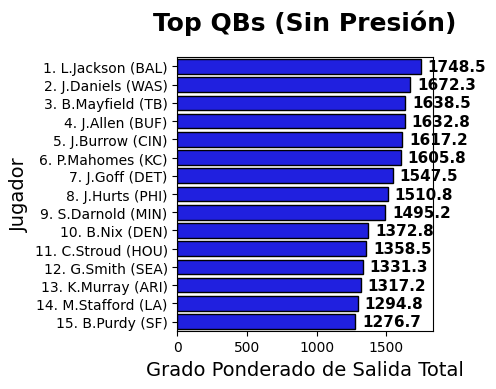

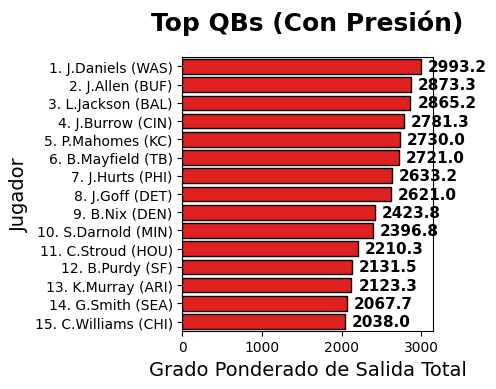

In [28]:
graficar_ranking(
    df=qb_ranking_sp_sorted,
    col_valor='valor_generado_TOTAL',
    col_nombre='jugador',
    col_equipo='equipo',
    titulo='Top QBs (Sin Presión)',
    color_base='blue',
    etiqueta_eje_x='Grado Ponderado de Salida Total'
)

graficar_ranking(
    df=qb_ranking_cp_sorted,
    col_valor='valor_generado_TOTAL',
    col_nombre='jugador',
    col_equipo='equipo',
    titulo='Top QBs (Con Presión)',
    color_base='red',
    etiqueta_eje_x='Grado Ponderado de Salida Total'
)

Rankeando receptores. Grado de salida ponderado total.

In [29]:
# Sin presión.
rec_ranking_sp = mpp_sp.groupby('jugador').agg(
    # Para la columna 'equipo', tomamos el último (o 'first')
    equipo=('equipo', 'last'),
    # Para 'in_strength_partido', la sumamos
    valor_recibido_TOTAL=('in_strength_partido', 'sum')
)

# Ordenamos
rec_ranking_sp_sorted = rec_ranking_sp.sort_values(by='valor_recibido_TOTAL', ascending=False)
# Reiniciamos el índice (esto crea una columna 'index' y un nuevo índice 0-N)
rec_ranking_sp_sorted = rec_ranking_sp_sorted.reset_index()
# Creamos el Rank empezando en 1
rec_ranking_sp_sorted.index = rec_ranking_sp_sorted.index + 1
rec_ranking_sp_sorted.index.name = 'Rank' # Nombramos el índice

rec_ranking_sp_sorted.head(15)

# Con presión.
rec_ranking_cp = mpp_cp.groupby('jugador').agg(
    # Para la columna 'equipo', tomamos el último (o 'first')
    equipo=('equipo', 'last'),
    # Para 'in_strength_partido', la sumamos
    valor_recibido_TOTAL=('in_strength_partido', 'sum')
)

rec_ranking_cp_sorted = rec_ranking_cp.sort_values(by='valor_recibido_TOTAL', ascending=False)
rec_ranking_cp_sorted = rec_ranking_cp_sorted.reset_index()
rec_ranking_cp_sorted.index = rec_ranking_cp_sorted.index + 1
rec_ranking_cp_sorted.index.name = 'Rank'

In [30]:
print("Ranking de WRs. Sin presión.")
rec_ranking_sp_sorted.head(15)

Ranking de WRs. Sin presión.


,jugador,equipo,valor_recibido_TOTAL
Rank,,,
1,J.Chase,CIN,484.666667
2,A.St. Brown,DET,482.166667
3,J.Jefferson,MIN,432.000000
4,T.McLaurin,WAS,426.500000
5,D.London,ATL,396.666667
6,D.Moore,CHI,386.333333
7,A.Brown,PHI,374.833333
8,L.McConkey,LAC,372.833333
9,M.Evans,TB,370.666667


In [31]:
print("Ranking de WRs. Con presión.")
rec_ranking_cp_sorted.head(15)

Ranking de WRs. Con presión.


,jugador,equipo,valor_recibido_TOTAL
Rank,,,
1,A.St. Brown,DET,904.500000
2,T.McLaurin,WAS,802.000000
3,J.Chase,CIN,742.000000
4,D.London,ATL,716.833333
5,J.Jefferson,MIN,712.500000
6,D.Moore,CHI,643.500000
7,A.Brown,PHI,642.666667
8,C.Sutton,DEN,641.166667
9,N.Collins,HOU,627.833333


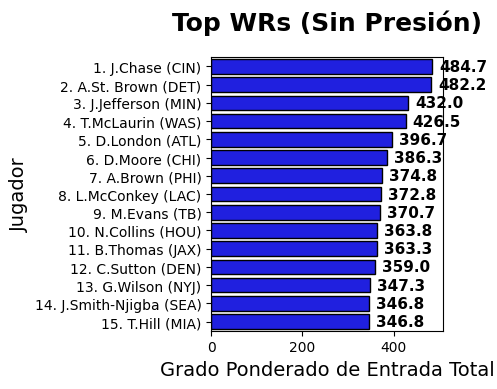

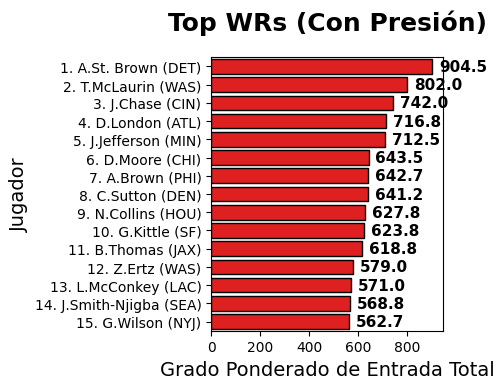

In [32]:
graficar_ranking(
    df=rec_ranking_sp_sorted,
    col_valor='valor_recibido_TOTAL',
    col_nombre='jugador',
    col_equipo='equipo',
    titulo='Top WRs (Sin Presión)',
    color_base='blue',
    etiqueta_eje_x='Grado Ponderado de Entrada Total'
)

graficar_ranking(
    df=rec_ranking_cp_sorted,
    col_valor='valor_recibido_TOTAL',
    col_nombre='jugador',
    col_equipo='equipo',
    titulo='Top WRs (Con Presión)',
    color_base='red',
    etiqueta_eje_x='Grado Ponderado de Entrada Total'
)

Ranking de Running Backs. Centralidad intermedia total.

In [33]:
rb_ranking_sp = mpp_sp.groupby('jugador').agg(
    equipo=('equipo', 'last'),
    # Sumamos la métrica de betweenness
    betweenness_TOTAL=('betweenness_partido', 'sum')
)

# Ordenamos
rb_ranking_sp = rb_ranking_sp.sort_values(by='betweenness_TOTAL', ascending=False)
# Ranking (Reset index + 1)
rb_ranking_sp = rb_ranking_sp.reset_index()
rb_ranking_sp.index = rb_ranking_sp.index + 1
rb_ranking_sp.index.name = 'Rank'


rb_ranking_cp = mpp_cp.groupby('jugador').agg(
    equipo=('equipo', 'last'),
    # Sumamos la métrica de betweenness
    betweenness_TOTAL=('betweenness_partido', 'sum')
)

# Ordenamos
rb_ranking_cp = rb_ranking_cp.sort_values(by='betweenness_TOTAL', ascending=False)
# Ranking (Reset index + 1)
rb_ranking_cp = rb_ranking_cp.reset_index()
rb_ranking_cp.index = rb_ranking_cp.index + 1
rb_ranking_cp.index.name = 'Rank'

In [34]:
print("Ranking de RBs. Sin presión.")
rb_ranking_sp.head(15)

Ranking de RBs. Sin presión.


,jugador,equipo,betweenness_TOTAL
Rank,,,
1,B.Robinson,WAS,0.305556
2,J.Gibbs,DET,0.214708
3,B.Hall,NYJ,0.197980
4,A.Jones,MIN,0.176190
5,A.Kamara,NO,0.163492
6,D.Achane,MIA,0.134946
7,C.Brown,CIN,0.134091
8,K.Williams,LA,0.129365
9,J.Jacobs,GB,0.117785


In [35]:
print("Ranking de RBs. Con presión.")
rb_ranking_cp.head(15)

Ranking de RBs. Con presión.


,jugador,equipo,betweenness_TOTAL
Rank,,,
1,B.Robinson,WAS,0.272222
2,J.Gibbs,DET,0.194408
3,B.Hall,NYJ,0.191234
4,A.Jones,MIN,0.162302
5,A.Kamara,NO,0.141270
6,K.Williams,LA,0.129365
7,D.Achane,MIA,0.127370
8,J.Goff,DET,0.097222
9,C.Brown,CIN,0.092424


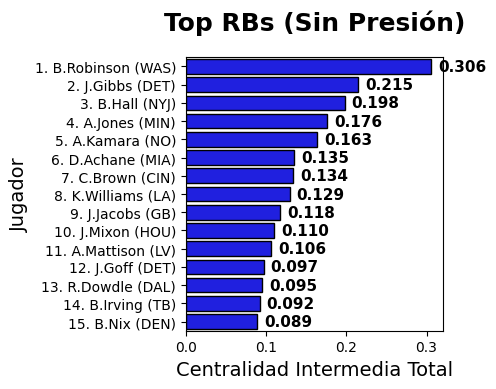

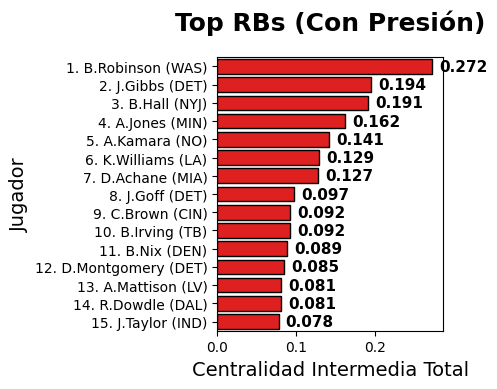

In [36]:
graficar_ranking(
    df=rb_ranking_sp,
    col_valor='betweenness_TOTAL',
    col_nombre='jugador',
    col_equipo='equipo',
    titulo='Top RBs (Sin Presión)',
    color_base='blue',
    etiqueta_eje_x='Centralidad Intermedia Total'
)

graficar_ranking(
    df=rb_ranking_cp,
    col_valor='betweenness_TOTAL',
    col_nombre='jugador',
    col_equipo='equipo',
    titulo='Top RBs (Con Presión)',
    color_base='red',
    etiqueta_eje_x='Centralidad Intermedia Total'
)

Rushers.

In [37]:
# 1. Agrupar y sumar rush_strength
rush_ranking_sp = mpp_sp.groupby('jugador').agg(
    equipo=('equipo', 'last'),
    # Sumamos la métrica específica de rush
    rush_strength_TOTAL=('rush_strength_partido', 'sum')
)

# 2. Ordenar
rush_ranking_sp = rush_ranking_sp.sort_values(by='rush_strength_TOTAL', ascending=False)

# 3. Crear Ranking (Reset index + 1)
rush_ranking_sp = rush_ranking_sp.reset_index()
rush_ranking_sp.index = rush_ranking_sp.index + 1
rush_ranking_sp.index.name = 'Rank'


# 1. Agrupar y sumar rush_strength (versión Con Presión)
rush_ranking_cp = mpp_cp.groupby('jugador').agg(
    equipo=('equipo', 'last'),
    # Sumamos la métrica específica de rush
    rush_strength_TOTAL=('rush_strength_partido', 'sum')
)

# 2. Ordenar
rush_ranking_cp = rush_ranking_cp.sort_values(by='rush_strength_TOTAL', ascending=False)

# 3. Crear Ranking (Reset index + 1)
rush_ranking_cp = rush_ranking_cp.reset_index()
rush_ranking_cp.index = rush_ranking_cp.index + 1
rush_ranking_cp.index.name = 'Rank'

In [38]:
# Rushers. Sin presión.
print("Ranking de rushers. Sin presión")
rush_ranking_sp.head(15)

Ranking de rushers. Sin presión


,jugador,equipo,rush_strength_TOTAL
Rank,,,
1,B.Robinson,WAS,855.166667
2,D.Henry,BAL,708.000000
3,S.Barkley,PHI,678.500000
4,K.Williams,LA,549.000000
5,J.Gibbs,DET,522.000000
6,J.Jacobs,GB,505.500000
7,J.Cook,BUF,457.833333
8,J.Taylor,IND,446.333333
9,J.Hurts,PHI,439.833333


In [39]:
# Rushers. Con presión.
print("Ranking de rushers. Con presión")
rush_ranking_cp.head(15)

Ranking de rushers. Con presión


,jugador,equipo,rush_strength_TOTAL
Rank,,,
1,B.Robinson,WAS,1327.166667
2,D.Henry,BAL,1014.500000
3,K.Williams,LA,929.000000
4,S.Barkley,PHI,926.833333
5,J.Hurts,PHI,898.500000
6,J.Gibbs,DET,879.833333
7,J.Jacobs,GB,743.166667
8,J.Allen,BUF,728.000000
9,J.Taylor,IND,708.833333


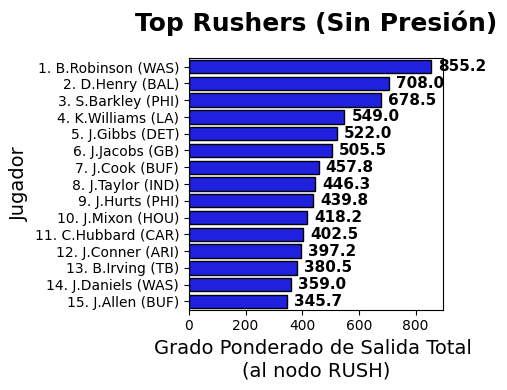

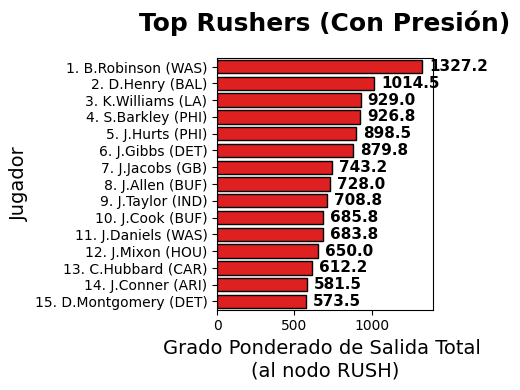

In [40]:
graficar_ranking(
    df=rush_ranking_sp,
    col_valor='rush_strength_TOTAL',
    col_nombre='jugador',
    col_equipo='equipo',
    titulo='Top Rushers (Sin Presión)',
    color_base='blue',
    etiqueta_eje_x='Grado Ponderado de Salida Total \n(al nodo RUSH)'
)

graficar_ranking(
    df=rush_ranking_cp,
    col_valor='rush_strength_TOTAL',
    col_nombre='jugador',
    col_equipo='equipo',
    titulo='Top Rushers (Con Presión)',
    color_base='red',
    etiqueta_eje_x='Grado Ponderado de Salida Total \n(al nodo RUSH)'
)

Puentes importantes para la conexidad del grafo. Centralidad de percolación total.

In [41]:
# Sin presión.
ranking_sp_perc = mpp_sp.groupby('jugador').agg(
    equipo=('equipo', 'last'),
    # Sumamos la métrica de percolación
    percolation_TOTAL=('percolation_partido', 'sum')
)

# Ordenamos
ranking_sp_perc = ranking_sp_perc.sort_values(by='percolation_TOTAL', ascending=False)
# Ranking
ranking_sp_perc = ranking_sp_perc.reset_index()
ranking_sp_perc.index = ranking_sp_perc.index + 1
ranking_sp_perc.index.name = 'Rank'

# Con presión.
ranking_cp_perc = mpp_cp.groupby('jugador').agg(
    equipo=('equipo', 'last'),
    percolation_TOTAL=('percolation_partido', 'sum')
)

# Ordenamos
ranking_cp_perc = ranking_cp_perc.sort_values(by='percolation_TOTAL', ascending=False)
# Ranking
ranking_cp_perc = ranking_cp_perc.reset_index()
ranking_cp_perc.index = ranking_cp_perc.index + 1
ranking_cp_perc.index.name = 'Rank'

In [42]:
print("Jugadores más importantes para la red de su equipo. Sin presión")
ranking_sp_perc.head(15)

Jugadores más importantes para la red de su equipo. Sin presión


,jugador,equipo,percolation_TOTAL
Rank,,,
1,B.Robinson,WAS,1.379494
2,J.Gibbs,DET,0.949860
3,B.Hall,NYJ,0.877393
4,D.Achane,MIA,0.677749
5,A.Jones,MIN,0.666575
6,C.Brown,CIN,0.634734
7,A.Kamara,NO,0.623403
8,J.Jacobs,GB,0.548360
9,K.Williams,LA,0.537302


In [43]:
print("Jugadores más importantes para la red de su equipo. Con presión")
ranking_cp_perc.head(15)

Jugadores más importantes para la red de su equipo. Con presión


,jugador,equipo,percolation_TOTAL
Rank,,,
1,B.Robinson,WAS,1.246161
2,B.Hall,NYJ,0.851839
3,J.Gibbs,DET,0.842536
4,D.Achane,MIA,0.634459
5,A.Jones,MIN,0.597130
6,A.Kamara,NO,0.506444
7,K.Williams,LA,0.471126
8,C.Brown,CIN,0.446534
9,R.Dowdle,DAL,0.375437


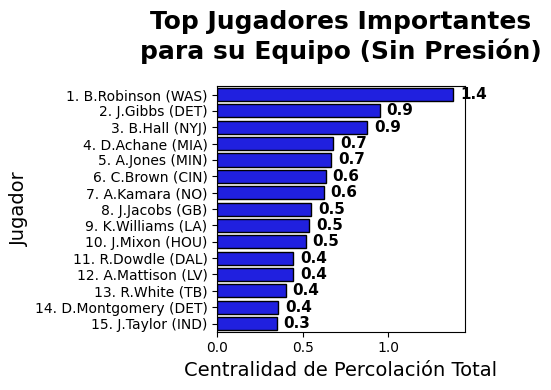

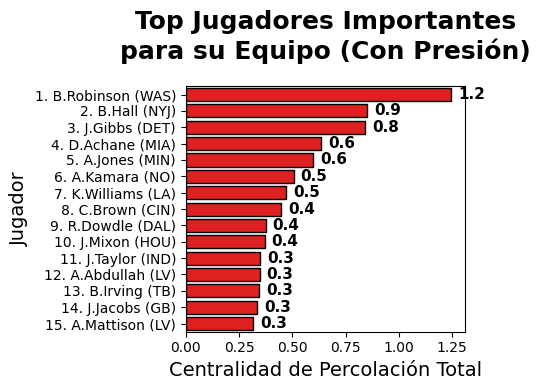

In [44]:
graficar_ranking(
    df=ranking_sp_perc,
    col_valor='percolation_TOTAL',
    col_nombre='jugador',
    col_equipo='equipo',
    titulo='Top Jugadores Importantes\npara su Equipo (Sin Presión)',
    color_base='blue',
    etiqueta_eje_x='Centralidad de Percolación Total'
)

graficar_ranking(
    df=ranking_cp_perc,
    col_valor='percolation_TOTAL',
    col_nombre='jugador',
    col_equipo='equipo',
    titulo='Top Jugadores Importantes\npara su Equipo (Con Presión)',
    color_base='red',
    etiqueta_eje_x='Centralidad de Percolación Total'
)

Métrica de valoración global ofensiva del equipo.

In [45]:
# Promedio de métricas 1 y 2.
valor_total_por_partido_cp = mpp_cp.groupby(['equipo', 'game_id'])['out_strength_partido'].sum() + mpp_cp.groupby(['equipo', 'game_id'])['in_strength_partido'].sum()
valor_total_por_partido_sp = mpp_sp.groupby(['equipo', 'game_id'])['out_strength_partido'].sum() + mpp_sp.groupby(['equipo', 'game_id'])['in_strength_partido'].sum()

ranking_rendimiento_global_cp_series = valor_total_por_partido_cp.groupby('equipo').sum().sort_values(ascending=False)
ranking_rendimiento_global_sp_series = valor_total_por_partido_sp.groupby('equipo').sum().sort_values(ascending=False)

ranking_global_sp = ranking_rendimiento_global_sp_series.reset_index()
ranking_global_sp.rename(columns={0: 'valor_promedio_partido'}, inplace=True)
ranking_global_sp.index = ranking_global_sp.index + 1
ranking_global_sp.index.name = 'Rank'


ranking_global_cp = ranking_rendimiento_global_cp_series.reset_index()
ranking_global_cp.rename(columns={0: 'valor_promedio_partido'}, inplace=True)
ranking_global_cp.index = ranking_global_cp.index + 1
ranking_global_cp.index.name = 'Rank'


In [46]:
print("Ranking de equipos. Sin presión")
ranking_global_sp.head(15)

Ranking de equipos. Sin presión


,equipo,valor_promedio_partido
Rank,,
1,DET,4113.333333
2,BAL,4050.833333
3,WAS,3982.333333
4,TB,3859.500000
5,PHI,3821.333333
6,BUF,3762.833333
7,KC,3696.500000
8,CIN,3606.833333
9,LA,3445.500000


In [47]:
print("Ranking de equipos. Con presión")
ranking_global_cp.head(15)

Ranking de equipos. Con presión


,equipo,valor_promedio_partido
Rank,,
1,WAS,6962.500000
2,DET,6931.500000
3,BAL,6522.333333
4,BUF,6362.166667
5,PHI,6268.166667
6,TB,6253.833333
7,KC,6194.833333
8,CIN,6106.500000
9,GB,5453.333333


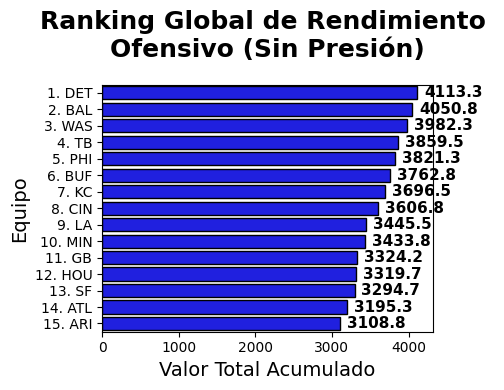

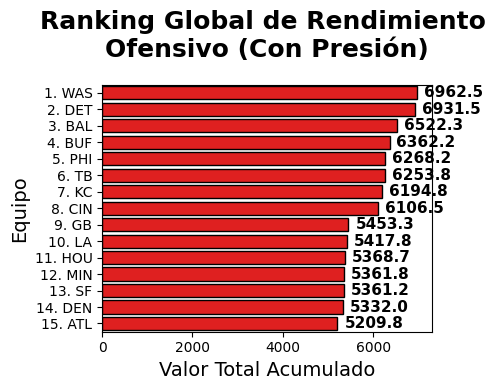

In [48]:
graficar_ranking_equipos(
    df=ranking_global_sp,
    col_valor='valor_promedio_partido',
    col_equipo='equipo',
    titulo='Ranking Global de Rendimiento \nOfensivo (Sin Presión)',
    color_base='blue',
    etiqueta_eje_x='Valor Total Acumulado'
)

graficar_ranking_equipos(
    df=ranking_global_cp,
    col_valor='valor_promedio_partido',
    col_equipo='equipo',
    titulo='Ranking Global de Rendimiento \nOfensivo (Con Presión)',
    color_base='red',
    etiqueta_eje_x='Valor Total Acumulado'
)

### Construcción del grafo y obtención de métricas. Iterando para todos los equipos. Tarda en correr y genera 150 MB de imágenes.

In [49]:
# Para romper el flujo de código y que no se generen los gráficos al correr todo.
break

SyntaxError: 'break' outside loop (ipython-input-3602731817.py, line 2)

Para las jugadas con presión.

In [ ]:
jugadas_ofensivas['valor_ponderado'] = jugadas_ofensivas['valor_base'] * jugadas_ofensivas['multiplicador_presion']

# Lista para guardar las métricas de CADA jugador en CADA partido.
all_game_metrics = []

# Creamos una carpeta para almacenar todos los grafos y no mostrarlos en pantalla.
output_folder_graphs = "grafos_por_equipo_2024_con_presion"
if not os.path.exists(output_folder_graphs):
    os.makedirs(output_folder_graphs)
    print(f"Carpeta '{output_folder_graphs}' creada para guardar los grafos.")

# Obtener lista de partidos. Sobre ellos iteraremos el ejemplo anterior.
game_ids = jugadas_ofensivas['game_id'].unique()
total_games = len(game_ids)
print(f"Iniciando análisis por partido para {total_games} juegos...")

# Ciclo sobre los id_games.
for i, game_id in enumerate(game_ids):
    # Usar replace para evitar caracteres inválidos en nombres de archivo.
    safe_game_id = game_id.replace('/', '_').replace('\\', '_')
    print(f"Procesando Partido {i+1}/{total_games}: {game_id}")

    # Filtrar jugadas solo de este partido
    df_partido = jugadas_ofensivas[jugadas_ofensivas['game_id'] == game_id]

    # Obtenemos datos del marcador que nos serán importantes para la información del gráfico.
    try:
        last_play = df_partido.iloc[-1]
        home_team = last_play['home_team']
        away_team = last_play['away_team']
        home_score = int(last_play['home_score'])
        away_score = int(last_play['away_score'])
        score_string = f"Resultado Final: {home_team} {home_score} - {away_team} {away_score}"
    except Exception as e:
        print(f"  Advertencia: No se pudo obtener el marcador final: {e}")
        score_string = "Resultado no disponible"

    # Identificar los equipos que jugaron
    equipos_partido = df_partido['posteam'].dropna().unique()

    # Iteramos para cada equipo del partido.
    for equipo in equipos_partido:
        # Filtrar jugadas ofensivas de cada equipo.
        df_equipo_partido = df_partido[df_partido['posteam'] == equipo]

        # Filtrar solo jugadas positivas para construir la red de este partido, son las que tuvieron éxito.
        jugadas_positivas_partido = df_equipo_partido[df_equipo_partido['valor_ponderado'] > 0]

        # Agregar Pases Positivos del Partido, aquellos que tienen lanzador y receptor.
        pases_partido = jugadas_positivas_partido[
            (jugadas_positivas_partido['play_type'] == 'pass') &
            (jugadas_positivas_partido['passer_player_name'].notna()) &
            (jugadas_positivas_partido['receiver_player_name'].notna())
        ]
        # Analizamos dichas conexiones, agrupando por pasador y receptor.
        # Tomamos la columna de valor ponderado y lo sumamos, para definir el peso de la arista entre ellos.
        conexiones_pases_partido = pases_partido.groupby(
            ['passer_player_name', 'receiver_player_name']
        )['valor_ponderado'].sum().reset_index()
        conexiones_pases_partido.rename(columns={'valor_ponderado': 'valor_total_conexion'}, inplace=True)

        # Ahora, los QBs muchas veces hacen jugadas individuales sin pase, por ello, definiremos un nodo especial de rush.
        # Este tipo de jugadas no son exclusivas del QB.
        # De las jugadas definidas, filtramos los rushes positivos del partido.
        rushes_partido = jugadas_positivas_partido[
            (jugadas_positivas_partido['play_type'] == 'run') &
            (jugadas_positivas_partido['rusher_player_name'].notna())
        ]
        valor_rush_partido = rushes_partido.groupby(
            ['rusher_player_name']
        )['valor_ponderado'].sum().reset_index()
        valor_rush_partido.rename(columns={'valor_ponderado': 'valor_total_conexion', 'rusher_player_name': 'jugador_origen'}, inplace=True)
        valor_rush_partido['nodo_destino'] = f"RUSH_{equipo}" # Nodo Rush.

        # Construcción del Grafo
        # Definimos el grafo.
        G_partido = nx.DiGraph()

        # Definimos una variable para el nodo de rush y lo agregamos al grafo.
        NODO_RUSH_EQUIPO = f"RUSH_{equipo}"
        G_partido.add_node(NODO_RUSH_EQUIPO, type='accion_rush', team=equipo)

        # Iteramos sobre los renglones de la tabla de conexiones.
        for _, row in conexiones_pases_partido.iterrows():
            # Tomamos el pasador y receptor, así como el valor del peso.
            passer = row['passer_player_name']
            receiver = row['receiver_player_name']
            weight = row.get('valor_total_conexion', 0)
            # Creamos nodos para el pasador, receptor y una arista para su conexión o enlace.
            G_partido.add_edge(passer, receiver,
                               weight=weight, type='pass')
            G_partido.add_node(passer, type='jugador', team=equipo)
            G_partido.add_node(receiver, type='jugador', team=equipo)

        # Ahora iteramos para los renglones de jugadas de rush.
        for _, row in valor_rush_partido.iterrows():
            # Tomamos el jugador que hizo el rush, así como el peso de la jugada. Como nodo destino es simplemente el que ya creamos.
            rusher = row['jugador_origen']
            weight = row.get('valor_total_conexion', 0)
            rush_node_destino = row['nodo_destino']
            # Si no existe el nodo para dicho jugador, lo agregamos.
            if not G_partido.has_node(rusher):
                G_partido.add_node(rusher, type='jugador', team=equipo)
            # Si ya existe, agregamos la arista que une al jugador con el nodo rush.
            G_partido.add_edge(rusher, rush_node_destino,
                               weight=weight, type='rush')

        # Cálculo y Almacenamiento de Métricas.
        # Nos aseguramos de que el grafo tenga nodos y aristas.
        if G_partido.number_of_nodes() > 1 and G_partido.number_of_edges() > 0:
            print(f"  Calculando métricas para {equipo}...")
            # Declarar métricas fuera del try para que existan
            in_strength, out_strength, in_degree, out_degree = {}, {}, {}, {}
            pagerank, betweenness, hubs, authorities, density = {}, {}, {}, {}, 0
            try:
                # Métricas Básicas (Grados y Fuerzas)
                in_strength = dict(G_partido.in_degree(weight='weight'))
                out_strength = dict(G_partido.out_degree(weight='weight'))
                in_degree = dict(G_partido.in_degree())
                out_degree = dict(G_partido.out_degree())

                # PageRank.
                pagerank = nx.pagerank(G_partido, weight='weight', alpha=0.9)

                # Betweenness Centrality.
                betweenness = nx.betweenness_centrality(G_partido, weight='costo', normalized=True)

                # HITS (Hubs y Autoridades)
                try:
                    hubs, authorities = nx.hits(G_partido, max_iter=500, tol=1.0e-4)
                except Exception as e_hits:
                     print(f"    Advertencia: No se pudo calcular HITS: {e_hits}")
                     hubs = {node: 0 for node in G_partido.nodes()}
                     authorities = {node: 0 for node in G_partido.nodes()}

                # Densidad
                density = nx.density(G_partido)

                # Percolación.
                try:
                    # Calcula la percolación para los estados "activos" (puedes ajustar esto)
                    percolation = nx.percolation_centrality(G_partido, weight='weight')
                except Exception as e_perc:
                    print(f"    Advertencia: No se pudo calcular Percolación: {e_perc}")
                    percolation = {node: 0 for node in G_partido.nodes()}
                # Guardar métricas del partido
                for node, data in G_partido.nodes(data=True):
                    node_id = node
                    # Solo guardamos métricas de jugadores reales
                    if data.get('type') == 'jugador':
                        valor_rush_jugador = sum([d['weight'] for u, v, d in G_partido.out_edges(node_id, data=True) if v.startswith('RUSH_')])
                        all_game_metrics.append({
                            'game_id': game_id,
                            'equipo': equipo,
                            'jugador': node_id,
                            'in_strength_partido': in_strength.get(node_id, 0),
                            'out_strength_partido': out_strength.get(node_id, 0),
                            'in_degree_partido': in_degree.get(node_id, 0),
                            'out_degree_partido': out_degree.get(node_id, 0),
                            'rush_strength_partido': valor_rush_jugador,
                            'pagerank_partido': pagerank.get(node_id, 0),
                            'betweenness_partido': betweenness.get(node_id, 0),
                            'hub_score_partido': hubs.get(node_id, 0),
                            'authority_score_partido': authorities.get(node_id, 0),
                            'percolation_partido': percolation.get(node_id, 0),
                            'densidad_grafo_partido': density
                        })

            except Exception as e:
                # Captura errores generales en el cálculo de métricas
                print(f"  Error calculando métricas para {equipo} en {game_id}: {e}")
        else:
            print(f"  Red vacía o sin aristas para {equipo}. No se calculan métricas.")


        # Dibujo del gráfico.
        # Comprobamos si las variables de métricas existen.
        if G_partido.number_of_nodes() > 1 and 'in_strength' in locals() and 'out_strength' in locals() and 'out_degree' in locals():
            # Paleta de colores.
            fondo_color = '#F0FDF4' # Fondo Menta muy claro
            titulo_color = '#052e16' # Verde Bosque oscuro
            subtitulo_color = '#44403c' # Gris cálido
            nodo_jugador_color = '#032110' # Verde Bosque oscuro
            nodo_rush_color = '#f97316' # Naranja brillante
            edge_pass_color = '#5A5E63' # Gris medio
            edge_rush_color = '#dc2626' # Rojo
            label_text_color = '#000000' # Texto negro
            bbox_color = '#FFFFFF'
            borde_nodo_color = '#73BA94' # Borde blanco
            borde_bandera_color = '#052e16'

            fig, ax = plt.subplots(figsize=(15, 12))
            #Color de fondo.
            ax.scatter([0], [0], s=10000000000, c=fondo_color, alpha=1, zorder=0)

            print(f"  Graficando red para {equipo}...")

            # Preparamos los atributos.
            # Tamaño de los nodos usando la fuerza de entrada y de salida.
            node_sizes = [ (in_strength.get(n, 0) + out_strength.get(n, 0)) * 20 + 500 if G_partido.nodes[n].get('type') == 'jugador' else 800 for n in G_partido.nodes()]
            # Colores de los nodos que hagan buen contraste con el fondo solarized.
            node_colors = ['#002b36' if G_partido.nodes[n].get('type') == 'jugador' else '#cb4b16' for n in G_partido.nodes()]

            # Layout de la red.
            # Separamos los qbs de otros jugadores, pues son la fuente principal de aristas.
            qbs = [n for n in G_partido.nodes() if out_degree.get(n, 0) > 0 and G_partido.nodes[n].get('type') == 'jugador']
            others = [n for n in G_partido.nodes() if n not in qbs]
            pos = None
            # Usamos un shell_layout y si no se puede, nos quedamos con spring_layout.
            if qbs and others:
                 try:
                     pos = nx.shell_layout(G_partido, [qbs, others])
                 except Exception as e_layout:
                     print(f"    Advertencia: Falló shell_layout ({e_layout}), usando spring_layout.")
                     pos = nx.spring_layout(G_partido, seed=42) # Seed para reproducibilidad
            else:
                 pos = nx.spring_layout(G_partido, seed=42)

            # Separar aristas en pases y rush.
            pass_edges = [(u,v) for u,v,d in G_partido.edges(data=True) if d.get('type')=='pass']
            rush_edges = [(u,v) for u,v,d in G_partido.edges(data=True) if d.get('type')=='rush']
            # Tomamos los pesos de cara arista.
            pass_weights = [G_partido[u][v].get('weight', 0) for u,v in pass_edges]
            rush_weights = [G_partido[u][v].get('weight', 0) for u,v in rush_edges]
            # Tomamos los valores maximos de los pesos de pase y rush.
            max_p_w = max(pass_weights) if pass_weights else 1
            max_r_w = max(rush_weights) if rush_weights else 1
            # Asegurar que el divisor no sea 0. En dado caso, tomaremos 1 como su valor.
            if max_p_w == 0: max_p_w = 1
            if max_r_w == 0: max_r_w = 1
            # Definimos el ancho de cada arista.
            pass_widths = [ (w/max_p_w)*8 + 1 for w in pass_weights ]
            rush_widths = [ (w/max_r_w)*8 + 1 for w in rush_weights ]

            # Posición de la etiqueta del nombre.
            label_pos = {}
            y_offset = 0.0
            for node, (x, y) in pos.items():
                label_pos[node] = (x, y + y_offset)

            # Caja para la etiqueta del nombre del jugador.
            label_bbox = {
                "facecolor": "#fdf6e3", # Fondo solarized
                "edgecolor": "none",
                "alpha": 0.8,
                "boxstyle": "round,pad=0.2"
            }

            # Dibujamos los nodos de G.
            nx.draw_networkx_nodes(G_partido, pos, ax=ax, node_size=node_sizes, node_color=node_colors, edgecolors='black', linewidths=0.5, alpha=0.9) # Borde negro

            # Dibujamos el nombre de cada jugador.
            nx.draw_networkx_labels(G_partido, label_pos, ax=ax, font_size=9, font_color = "#002b36", bbox=label_bbox, font_weight='bold', verticalalignment='bottom') # Añadido verticalalignment

            # Dibujamos las aristas de pases.
            nx.draw_networkx_edges(G_partido, pos, ax=ax, edgelist=pass_edges, width=pass_widths, edge_color='darkgoldenrod', alpha=0.6, arrowsize=20)

            # Dibujamos las aristas de rush.
            nx.draw_networkx_edges(G_partido, pos, ax=ax, edgelist=rush_edges, width=rush_widths, edge_color='indianred', alpha=0.7, arrowsize=20, connectionstyle='arc3, rad=0.1')


            # Encabezado de la gráfica. Titulos y subtitulos.
            # Colores y fuente
            color_titulo_principal = '#002b36'
            color_subtitulo = '#586e75'
            fuente = 'DejaVu Sans'
            # Título Principal (Partido)
            fig.text(
                0.5, 0.96, # Posición X, Y
                f"Red de Valor Positivo (Con presión) @ {game_id}",
                ha='center', va='bottom', fontsize=20, fontname=fuente,
                weight='bold', color=color_titulo_principal
            )
            # Subtítulo (Marcador)
            if 'score_string' in locals():
                fig.text(
                    0.5, 0.94, score_string,
                    ha='center', va='top', fontsize=14, fontname=fuente,
                    style='italic', color=color_subtitulo
                )
            # Título del Equipo con bandera.
            team_y_pos = 0.91
            fig.text(
                0.53, team_y_pos,
                equipo,
                ha='center', va='center',
                fontname=fuente, weight='bold', fontsize=16, color=color_titulo_principal
            )
            # Bandera del equipo.
            # Tamaño de la bandera y la centramos verticalmente.
            swatch_size = 0.015
            patch_y_pos = team_y_pos - (swatch_size / 2)
            # Obtener colores del equipo para la bandera.
            primary_color, secondary_color = NFL_TEAM_COLORS_PALETTE.get(equipo, DEFAULT_COLORS)
            # Posición de la bandera.
            flag_start_x = 0.47
            # Bandera indicadora del equipo.
            fig.patches.extend([
                plt.Rectangle(
                    (flag_start_x, patch_y_pos),
                    swatch_size, swatch_size, # width, height
                    facecolor=primary_color,
                    edgecolor=borde_bandera_color,
                    transform=fig.transFigure, figure=fig
                )
            ])
            fig.patches.extend([
                plt.Rectangle(
                    (flag_start_x + swatch_size, patch_y_pos), # Se coloca justo después del primario
                    swatch_size, swatch_size, # width, height
                    facecolor=secondary_color,
                    edgecolor=borde_bandera_color,
                    transform=fig.transFigure, figure=fig
                )
            ])
            # Quitamos los ejes.
            plt.axis('off')

            # Guardar los gráficos y no mostrarlos.
            graph_filename = f"{output_folder_graphs}/red_{equipo}_{safe_game_id}.png"
            plt.savefig(graph_filename, dpi=100, bbox_inches='tight', facecolor=fig.get_facecolor())
            plt.close(fig) # Liberar memoria
            print(f"    Grafo guardado en: {graph_filename}")
        else:
            print(f"  No se grafica la red para {equipo} (vacía o sin métricas calculadas).")

print("\n--- Análisis por partido completado ---")

# Agregamos las métricas y las guardamos como un csv.

print("\nCreando DataFrame de métricas por partido...")
df_game_metrics = pd.DataFrame(all_game_metrics)
csv_filename_raw = "metricas_por_partido_con_presion_2024.csv"
df_game_metrics.to_csv(csv_filename_raw, index=False, encoding='utf-8-sig')

print(f"\n Métricas por partido guardadas en '{csv_filename_raw}'")

print("\n Proceso Finalizado")
print(f"Se generaron los grafos en la carpeta: '{output_folder_graphs}'")
print(f"Se generó el CSV con las métricas en: '{csv_filename_raw}'")

Para las jugadas sin presión.

In [ ]:
jugadas_ofensivas['valor_ponderado'] = jugadas_ofensivas['valor_base']

# Lista para guardar las métricas de CADA jugador en CADA partido.
all_game_metrics = []

# Creamos una carpeta para almacenar todos los grafos y no mostrarlos en pantalla.
output_folder_graphs = "grafos_por_equipo_2024_sin_presion"
if not os.path.exists(output_folder_graphs):
    os.makedirs(output_folder_graphs)
    print(f"Carpeta '{output_folder_graphs}' creada para guardar los grafos.")

# Obtener lista de partidos. Sobre ellos iteraremos el ejemplo anterior.
game_ids = jugadas_ofensivas['game_id'].unique()
total_games = len(game_ids)
print(f"Iniciando análisis por partido para {total_games} juegos...")

# Ciclo sobre los id_games.
for i, game_id in enumerate(game_ids):
    # Usar replace para evitar caracteres inválidos en nombres de archivo.
    safe_game_id = game_id.replace('/', '_').replace('\\', '_')
    print(f"Procesando Partido {i+1}/{total_games}: {game_id}")

    # Filtrar jugadas solo de este partido
    df_partido = jugadas_ofensivas[jugadas_ofensivas['game_id'] == game_id]

    # Obtenemos datos del marcador que nos serán importantes para la información del gráfico.
    try:
        last_play = df_partido.iloc[-1]
        home_team = last_play['home_team']
        away_team = last_play['away_team']
        home_score = int(last_play['home_score'])
        away_score = int(last_play['away_score'])
        score_string = f"Resultado Final: {home_team} {home_score} - {away_team} {away_score}"
    except Exception as e:
        print(f"  Advertencia: No se pudo obtener el marcador final: {e}")
        score_string = "Resultado no disponible"

    # Identificar los equipos que jugaron
    equipos_partido = df_partido['posteam'].dropna().unique()

    # Iteramos para cada equipo del partido.
    for equipo in equipos_partido:
        # Filtrar jugadas ofensivas de cada equipo.
        df_equipo_partido = df_partido[df_partido['posteam'] == equipo]

        # Filtrar solo jugadas positivas para construir la red de este partido, son las que tuvieron éxito.
        jugadas_positivas_partido = df_equipo_partido[df_equipo_partido['valor_ponderado'] > 0]

        # Agregar Pases Positivos del Partido, aquellos que tienen lanzador y receptor.
        pases_partido = jugadas_positivas_partido[
            (jugadas_positivas_partido['play_type'] == 'pass') &
            (jugadas_positivas_partido['passer_player_name'].notna()) &
            (jugadas_positivas_partido['receiver_player_name'].notna())
        ]
        # Analizamos dichas conexiones, agrupando por pasador y receptor.
        # Tomamos la columna de valor ponderado y lo sumamos, para definir el peso de la arista entre ellos.
        conexiones_pases_partido = pases_partido.groupby(
            ['passer_player_name', 'receiver_player_name']
        )['valor_ponderado'].sum().reset_index()
        conexiones_pases_partido.rename(columns={'valor_ponderado': 'valor_total_conexion'}, inplace=True)

        # Ahora, los QBs muchas veces hacen jugadas individuales sin pase, por ello, definiremos un nodo especial de rush.
        # Este tipo de jugadas no son exclusivas del QB.
        # De las jugadas definidas, filtramos los rushes positivos del partido.
        rushes_partido = jugadas_positivas_partido[
            (jugadas_positivas_partido['play_type'] == 'run') &
            (jugadas_positivas_partido['rusher_player_name'].notna())
        ]
        valor_rush_partido = rushes_partido.groupby(
            ['rusher_player_name']
        )['valor_ponderado'].sum().reset_index()
        valor_rush_partido.rename(columns={'valor_ponderado': 'valor_total_conexion', 'rusher_player_name': 'jugador_origen'}, inplace=True)
        valor_rush_partido['nodo_destino'] = f"RUSH_{equipo}" # Nodo Rush.

        # Construcción del Grafo
        # Definimos el grafo.
        G_partido = nx.DiGraph()

        # Definimos una variable para el nodo de rush y lo agregamos al grafo.
        NODO_RUSH_EQUIPO = f"RUSH_{equipo}"
        G_partido.add_node(NODO_RUSH_EQUIPO, type='accion_rush', team=equipo)

        # Iteramos sobre los renglones de la tabla de conexiones.
        for _, row in conexiones_pases_partido.iterrows():
            # Tomamos el pasador y receptor, así como el valor del peso.
            passer = row['passer_player_name']
            receiver = row['receiver_player_name']
            weight = row.get('valor_total_conexion', 0)
            # Creamos nodos para el pasador, receptor y una arista para su conexión o enlace.
            G_partido.add_edge(passer, receiver,
                               weight=weight, type='pass')
            G_partido.add_node(passer, type='jugador', team=equipo)
            G_partido.add_node(receiver, type='jugador', team=equipo)

        # Ahora iteramos para los renglones de jugadas de rush.
        for _, row in valor_rush_partido.iterrows():
            # Tomamos el jugador que hizo el rush, así como el peso de la jugada. Como nodo destino es simplemente el que ya creamos.
            rusher = row['jugador_origen']
            weight = row.get('valor_total_conexion', 0)
            rush_node_destino = row['nodo_destino']
            # Si no existe el nodo para dicho jugador, lo agregamos.
            if not G_partido.has_node(rusher):
                G_partido.add_node(rusher, type='jugador', team=equipo)
            # Si ya existe, agregamos la arista que une al jugador con el nodo rush.
            G_partido.add_edge(rusher, rush_node_destino,
                               weight=weight, type='rush')

        # Cálculo y Almacenamiento de Métricas.
        # Nos aseguramos de que el grafo tenga nodos y aristas.
        if G_partido.number_of_nodes() > 1 and G_partido.number_of_edges() > 0:
            print(f"  Calculando métricas para {equipo}...")
            # Declarar métricas fuera del try para que existan
            in_strength, out_strength, in_degree, out_degree = {}, {}, {}, {}
            pagerank, betweenness, hubs, authorities, density = {}, {}, {}, {}, 0
            try:
                # Métricas Básicas (Grados y Fuerzas)
                in_strength = dict(G_partido.in_degree(weight='weight'))
                out_strength = dict(G_partido.out_degree(weight='weight'))
                in_degree = dict(G_partido.in_degree())
                out_degree = dict(G_partido.out_degree())

                # PageRank.
                pagerank = nx.pagerank(G_partido, weight='weight', alpha=0.9)

                # Betweenness Centrality.
                betweenness = nx.betweenness_centrality(G_partido, weight='costo', normalized=True)

                # HITS (Hubs y Autoridades)
                try:
                    hubs, authorities = nx.hits(G_partido, max_iter=500, tol=1.0e-4)
                except Exception as e_hits:
                     print(f"    Advertencia: No se pudo calcular HITS: {e_hits}")
                     hubs = {node: 0 for node in G_partido.nodes()}
                     authorities = {node: 0 for node in G_partido.nodes()}

                # Densidad
                density = nx.density(G_partido)

                # Percolación.
                try:
                    # Calcula la percolación para los estados "activos" (puedes ajustar esto)
                    percolation = nx.percolation_centrality(G_partido, weight='weight')
                except Exception as e_perc:
                    print(f"    Advertencia: No se pudo calcular Percolación: {e_perc}")
                    percolation = {node: 0 for node in G_partido.nodes()}
                # Guardar métricas del partido
                for node, data in G_partido.nodes(data=True):
                    node_id = node
                    # Solo guardamos métricas de jugadores reales
                    if data.get('type') == 'jugador':
                        valor_rush_jugador = sum([d['weight'] for u, v, d in G_partido.out_edges(node_id, data=True) if v.startswith('RUSH_')])
                        all_game_metrics.append({
                            'game_id': game_id,
                            'equipo': equipo,
                            'jugador': node_id,
                            'in_strength_partido': in_strength.get(node_id, 0),
                            'out_strength_partido': out_strength.get(node_id, 0),
                            'in_degree_partido': in_degree.get(node_id, 0),
                            'out_degree_partido': out_degree.get(node_id, 0),
                            'rush_strength_partido': valor_rush_jugador,
                            'pagerank_partido': pagerank.get(node_id, 0),
                            'betweenness_partido': betweenness.get(node_id, 0),
                            'hub_score_partido': hubs.get(node_id, 0),
                            'authority_score_partido': authorities.get(node_id, 0),
                            'percolation_partido': percolation.get(node_id, 0),
                            'densidad_grafo_partido': density
                        })

            except Exception as e:
                # Captura errores generales en el cálculo de métricas
                print(f"  Error calculando métricas para {equipo} en {game_id}: {e}")
        else:
            print(f"  Red vacía o sin aristas para {equipo}. No se calculan métricas.")


        # Dibujo del gráfico.
        # Comprobamos si las variables de métricas existen.
        if G_partido.number_of_nodes() > 1 and 'in_strength' in locals() and 'out_strength' in locals() and 'out_degree' in locals():
            # Paleta de colores.
            fondo_color = '#F0FDF4' # Fondo Menta muy claro
            titulo_color = '#052e16' # Verde Bosque oscuro
            subtitulo_color = '#44403c' # Gris cálido
            nodo_jugador_color = '#032110' # Verde Bosque oscuro
            nodo_rush_color = '#f97316' # Naranja brillante
            edge_pass_color = '#5A5E63' # Gris medio
            edge_rush_color = '#dc2626' # Rojo
            label_text_color = '#000000' # Texto negro
            bbox_color = '#FFFFFF'
            borde_nodo_color = '#73BA94' # Borde blanco
            borde_bandera_color = '#052e16'
            fig, ax = plt.subplots(figsize=(15, 12))
            #Color de fondo.
            ax.scatter([0], [0], s=10000000000, c=fondo_color, alpha=1, zorder=0)

            print(f"  Graficando red para {equipo}...")

            # Preparamos los atributos.
            # Tamaño de los nodos usando la fuerza de entrada y de salida.
            node_sizes = [ (in_strength.get(n, 0) + out_strength.get(n, 0)) * 20 + 500 if G_partido.nodes[n].get('type') == 'jugador' else 800 for n in G_partido.nodes()]
            # Colores de los nodos que hagan buen contraste con el fondo solarized.
            node_colors = ['#002b36' if G_partido.nodes[n].get('type') == 'jugador' else '#cb4b16' for n in G_partido.nodes()]

            # Layout de la red.
            # Separamos los qbs de otros jugadores, pues son la fuente principal de aristas.
            qbs = [n for n in G_partido.nodes() if out_degree.get(n, 0) > 0 and G_partido.nodes[n].get('type') == 'jugador']
            others = [n for n in G_partido.nodes() if n not in qbs]
            pos = None
            # Usamos un shell_layout y si no se puede, nos quedamos con spring_layout.
            if qbs and others:
                 try:
                     pos = nx.shell_layout(G_partido, [qbs, others])
                 except Exception as e_layout:
                     print(f"    Advertencia: Falló shell_layout ({e_layout}), usando spring_layout.")
                     pos = nx.spring_layout(G_partido, seed=42) # Seed para reproducibilidad
            else:
                 pos = nx.spring_layout(G_partido, seed=42)

            # Separar aristas en pases y rush.
            pass_edges = [(u,v) for u,v,d in G_partido.edges(data=True) if d.get('type')=='pass']
            rush_edges = [(u,v) for u,v,d in G_partido.edges(data=True) if d.get('type')=='rush']
            # Tomamos los pesos de cara arista.
            pass_weights = [G_partido[u][v].get('weight', 0) for u,v in pass_edges]
            rush_weights = [G_partido[u][v].get('weight', 0) for u,v in rush_edges]
            # Tomamos los valores maximos de los pesos de pase y rush.
            max_p_w = max(pass_weights) if pass_weights else 1
            max_r_w = max(rush_weights) if rush_weights else 1
            # Asegurar que el divisor no sea 0. En dado caso, tomaremos 1 como su valor.
            if max_p_w == 0: max_p_w = 1
            if max_r_w == 0: max_r_w = 1
            # Definimos el ancho de cada arista.
            pass_widths = [ (w/max_p_w)*8 + 1 for w in pass_weights ]
            rush_widths = [ (w/max_r_w)*8 + 1 for w in rush_weights ]

            # Posición de la etiqueta del nombre.
            label_pos = {}
            y_offset = 0.0
            for node, (x, y) in pos.items():
                label_pos[node] = (x, y + y_offset)

            # Caja para la etiqueta del nombre del jugador.
            label_bbox = {
                "facecolor": "#fdf6e3", # Fondo solarized
                "edgecolor": "none",
                "alpha": 0.8,
                "boxstyle": "round,pad=0.2"
            }

            # Dibujamos los nodos de G.
            nx.draw_networkx_nodes(G_partido, pos, ax=ax, node_size=node_sizes, node_color=node_colors, edgecolors='black', linewidths=0.5, alpha=0.9) # Borde negro

            # Dibujamos el nombre de cada jugador.
            nx.draw_networkx_labels(G_partido, label_pos, ax=ax, font_size=9, font_color = "#002b36", bbox=label_bbox, font_weight='bold', verticalalignment='bottom') # Añadido verticalalignment

            # Dibujamos las aristas de pases.
            nx.draw_networkx_edges(G_partido, pos, ax=ax, edgelist=pass_edges, width=pass_widths, edge_color='darkgoldenrod', alpha=0.6, arrowsize=20)

            # Dibujamos las aristas de rush.
            nx.draw_networkx_edges(G_partido, pos, ax=ax, edgelist=rush_edges, width=rush_widths, edge_color='indianred', alpha=0.7, arrowsize=20, connectionstyle='arc3, rad=0.1')


            # Encabezado de la gráfica. Titulos y subtitulos.
            # Colores y fuente
            color_titulo_principal = '#002b36'
            color_subtitulo = '#586e75'
            fuente = 'DejaVu Sans'
            # Título Principal (Partido)
            fig.text(
                0.5, 0.96, # Posición X, Y
                f"Red de Valor Positivo (Sin presión) @ {game_id}",
                ha='center', va='bottom', fontsize=20, fontname=fuente,
                weight='bold', color=color_titulo_principal
            )
            # Subtítulo (Marcador)
            if 'score_string' in locals():
                fig.text(
                    0.5, 0.94, score_string,
                    ha='center', va='top', fontsize=14, fontname=fuente,
                    style='italic', color=color_subtitulo
                )
            # Título del Equipo con bandera.
            team_y_pos = 0.91
            fig.text(
                0.53, team_y_pos,
                equipo,
                ha='center', va='center',
                fontname=fuente, weight='bold', fontsize=16, color=color_titulo_principal
            )
            # Bandera del equipo.
            # Tamaño de la bandera y la centramos verticalmente.
            swatch_size = 0.015
            patch_y_pos = team_y_pos - (swatch_size / 2)
            # Obtener colores del equipo para la bandera.
            primary_color, secondary_color = NFL_TEAM_COLORS_PALETTE.get(equipo, DEFAULT_COLORS)
            # Posición de la bandera.
            flag_start_x = 0.47
            # Bandera indicadora del equipo.
            fig.patches.extend([
                plt.Rectangle(
                    (flag_start_x, patch_y_pos),
                    swatch_size, swatch_size, # width, height
                    facecolor=primary_color,
                    edgecolor=borde_bandera_color,
                    transform=fig.transFigure, figure=fig
                )
            ])
            fig.patches.extend([
                plt.Rectangle(
                    (flag_start_x + swatch_size, patch_y_pos), # Se coloca justo después del primario
                    swatch_size, swatch_size, # width, height
                    facecolor=secondary_color,
                    edgecolor=borde_bandera_color,
                    transform=fig.transFigure, figure=fig
                )
            ])
            # Quitamos los ejes.
            plt.axis('off')

            # Guardar los gráficos y no mostrarlos.
            graph_filename = f"{output_folder_graphs}/red_{equipo}_{safe_game_id}.png"
            plt.savefig(graph_filename, dpi=100, bbox_inches='tight', facecolor=fig.get_facecolor())
            plt.close(fig) # Liberar memoria
            print(f"    Grafo guardado en: {graph_filename}")
        else:
            print(f"  No se grafica la red para {equipo} (vacía o sin métricas calculadas).")

print("\n--- Análisis por partido completado ---")

# Agregamos las métricas y las guardamos como un csv.

print("\nCreando DataFrame de métricas por partido...")
df_game_metrics = pd.DataFrame(all_game_metrics)
csv_filename_raw = "metricas_por_partido_sin_presion_2024.csv"
df_game_metrics.to_csv(csv_filename_raw, index=False, encoding='utf-8-sig')

print(f"\n Métricas por partido guardadas en '{csv_filename_raw}'")

print("\n Proceso Finalizado")
print(f"Se generaron los grafos en la carpeta: '{output_folder_graphs}'")
print(f"Se generó el CSV con las métricas en: '{csv_filename_raw}'")